## Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.metrics import precision_score, recall_score, accuracy_score
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

## Helper Functions Feature Extraction
* Hog features
* Spatial features
* Histogram features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    hist_features1, _ = np.histogram(img[:,:,0], bins=nbins) 
    hist_features2, _ = np.histogram(img[:,:,1], bins=nbins)
    hist_features3, _ = np.histogram(img[:,:,2], bins=nbins)
    
    hist_features = np.concatenate((hist_features1, hist_features2, hist_features3))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    count = 0
    for file in imgs:
        count = count + 1
        file_features = []
        # Read in each one by one, RGB
        image = mpimg.imread(file)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            hog_features = []
            if hog_channel == "ALL":
                for channel in range(feature_image.shape[2]):
                    hog_features_channel = get_hog_features(feature_image[:,:,channel], orient,
                                                           pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                    hog_features.append(hog_features_channel)
                hog_features = np.ravel(hog_features)
                
            else:
                # Call get_hog_features() with vis=False, feature_vec=True
                hog_features = get_hog_features(feature_image, orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Helper Functions HeapMap and Box
* Heap map
* Thresholding box
* Combine boxes

In [3]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    #print(len(bbox_list))
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    #plt.imshow(heatmap, cmap='hot')
    #plt.show()
    print('Max: ' + str(np.max(heatmap)))
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    #print(type(heatmap))
    #print(heatmap.shape)
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(draw_img, labels):
    imgcopy = np.copy(draw_img)

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        color = (255, 0, 0)
        cv2.rectangle(imgcopy, bbox[0], bbox[1], color, 10)
    # Return the image
    return imgcopy

## Extract all Training Features

In [4]:
# Set parameters for feature extraction
color_space = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9                # HOG orientation
pix_per_cell = 8 #4       # HOG pixels per cell
cell_per_block = 2  #4    # HOG cells per bock
hog_channel = "ALL"       # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)   # Spatial binning dimensions
hist_bins = 16            # Number of histogram bins
spatial_feat = True       # Spatial features on or off
hist_feat = True          # Histogram features on or off
hog_feat = True           # HOG features on or off

train_flag = False         # Train new model or load saved model
linear_flag = True        # Linear or NonLinear Kernel 
extract_flag = False      # Extract training features or load saved features
reduce_flag = False       # Reduce samples or not
sample_size = 5000        # Subsample size


if train_flag:
    # Extract training features otherwise load saved one
    t1 = time.time()
    if extract_flag:
        # Read in cars and notcars
        images = glob.glob('*/*/*.png')
        cars = []
        notcars = []
        
        # Read images
        for image in images:
            if 'non' in image:
                notcars.append(image)
            else:
                cars.append(image)
                
        print(len(notcars), len(cars))
        
        # Extract features
        car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        
        notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        # Save features:
        with open("trainingCar1.pickle", "wb") as output_file:
            pickle.dump((car_features[:3000]), output_file)
            
        with open("trainingCar2.pickle", "wb") as output_file:
            pickle.dump((car_features[3000:6000]), output_file)
            
        with open("trainingCar3.pickle", "wb") as output_file:
            pickle.dump((car_features[6000:]), output_file)
            
        with open("trainingNotCar1.pickle", "wb") as output_file:
            pickle.dump((notcar_features[:3000]), output_file)
        
        with open("trainingNotCar2.pickle", "wb") as output_file:
            pickle.dump((notcar_features[3000:6000]), output_file)
            
        with open("trainingNotCar3.pickle", "wb") as output_file:
            pickle.dump((notcar_features[6000:]), output_file)
            
        print("Saved pickle files")
    
    else:
        if sample_size < 3000:
            with open("trainingCar1.pickle", "rb") as input_file:
                car_features = pickle.load(input_file)
                
            with open("trainingNotCar1.pickle", "rb") as input_file:
                notcar_features = pickle.load(input_file)
                
        elif sample_size < 6000:
            with open("trainingCar1.pickle", "rb") as input_file:
                car_features1 = pickle.load(input_file)
                
            with open("trainingNotCar1.pickle", "rb") as input_file:
                notcar_features1 = pickle.load(input_file)
                
            with open("trainingCar2.pickle", "rb") as input_file:
                car_features2 = pickle.load(input_file)
                
            with open("trainingNotCar2.pickle", "rb") as input_file:
                notcar_features2 = pickle.load(input_file)
            
            car_features = np.vstack((car_features1, car_features2))
            notcar_features = np.vstack((notcar_features1, notcar_features2))
            
        else:
            with open("trainingCar1.pickle", "rb") as input_file:
                car_features1 = pickle.load(input_file)
                
            with open("trainingNotCar1.pickle", "rb") as input_file:
                notcar_features1 = pickle.load(input_file)
                
            with open("trainingCar2.pickle", "rb") as input_file:
                car_features2 = pickle.load(input_file)
                
            with open("trainingNotCar2.pickle", "rb") as input_file:
                notcar_features2 = pickle.load(input_file)
            
            with open("trainingCar3.pickle", "rb") as input_file:
                car_features3 = pickle.load(input_file)
                
            with open("trainingNotCar3.pickle", "rb") as input_file:
                notcar_features3 = pickle.load(input_file)
            
            car_features = np.vstack((car_features1, car_features2, car_features3))
            notcar_features = np.vstack((notcar_features1, notcar_features2, notcar_features3))
            
        # load saved features
        print("Loaded training.pickle")
    
    
    # Reduce the sample size because
    if reduce_flag :
        car_features = car_features[:sample_size+1]
        notcar_features = notcar_features[:sample_size+1]
        
    # Concatenate car and noncar features    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = 19
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Feature vector length:', len(X_train[0]))
    print('Training samples: ' + str(len(y_train)))
    print('Testing samples: ' + str(len(y_test)))
        
    t2 = time.time()
    print('Using', str(t2-t1), ' seconds to prepare training data.')
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')


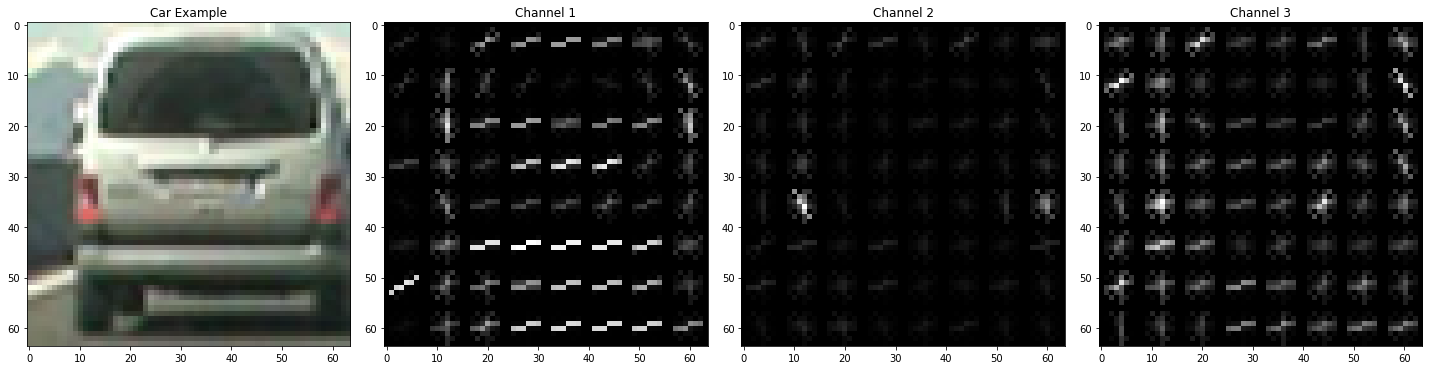

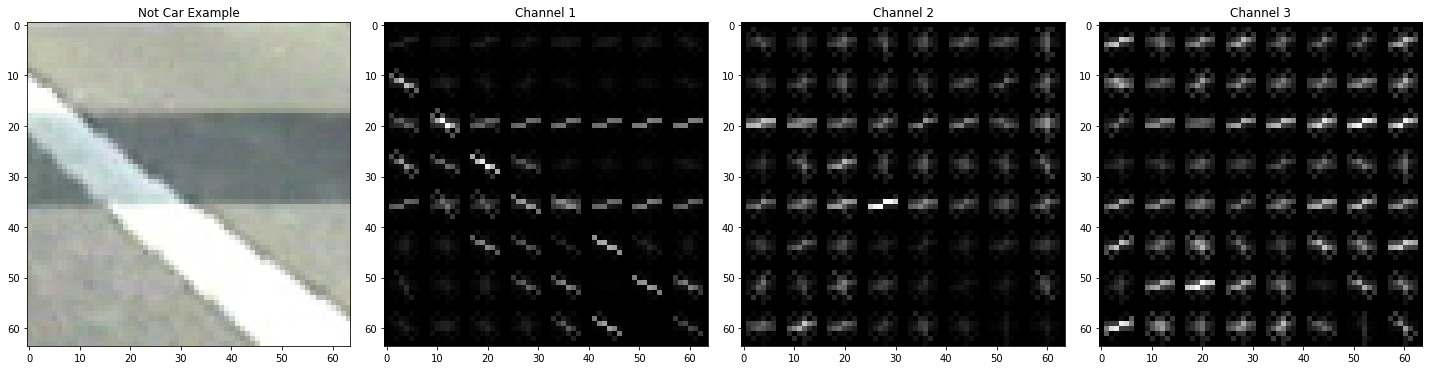

In [5]:
def demo_hog(img, name_string):
    image = mpimg.imread(img)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    _, chan1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                                         vis=True, feature_vec=False)
    _, chan2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                                         vis=True, feature_vec=False)
    _, chan3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                                         vis=True, feature_vec=False)
    
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.imshow(image)
    plt.title(name_string)
    plt.subplot(142)
    plt.imshow(chan1, cmap = 'gray')
    plt.title('Channel 1')
    plt.subplot(143)
    plt.imshow(chan2, cmap = 'gray')
    plt.title('Channel 2')
    plt.subplot(144)
    plt.imshow(chan3, cmap = 'gray')
    plt.title('Channel 3')
    plt.tight_layout()
    plt.show()

    
chan1 = demo_hog('vehicles/GTI_MiddleClose/image0123.png', 'Car Example')
chan2 = demo_hog('non-vehicles/GTI/image3875.png', 'Not Car Example')

##  Train SVM Classifier

In [6]:
if train_flag:
    # Use a linear SVC 
    from sklearn import svm
    
    if linear_flag:
        svc = LinearSVC(C=10**(0))
        pickle_file = "modelLinear.pickle"
    else:
        svc = svm.SVC(C=10, kernel='rbf')
        pickle_file = "modelRBF.pickle"

    print('Training...')
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    with open(pickle_file, "wb") as output_file:
        pickle.dump((svc, X_scaler), output_file)
    
    # Check the score of the SVC
    print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    y_pred = svc.predict(X_test)
    print('Test Precision Score of SVC = ', round(precision_score(y_test, y_pred), 4))
    print('Test Recall Score of SVC = ', round(recall_score(y_test, y_pred), 4))
        
else:
    print("Loading model...")
    if linear_flag:
        with open("modelLinear.pickle", "rb") as input_file:
            print("Linear...")
            model = pickle.load(input_file)
            svc = model[0]
            X_scaler = model[1]
    else:
        with open("modelRBF.pickle", "rb") as input_file:
            print("Nonlinear...")
            model = pickle.load(input_file)
            svc = model[0]
            X_scaler = model[1]



Loading model...
Linear...


Training...  
27.79 Seconds to train SVC...  
Train Accuracy of SVC =  1.0  
Test Accuracy of SVC =  0.9921  
Test Precision Score of SVC =  0.9917  
Test Recall Score of SVC =  0.9928  

## Grid Search Parameters for SVM

In [7]:
def predict(clf, thr, X):
    y_prob = clf.predict_proba(X)
    y_pred = np.array([1 if x[1] > thr else 0 for x in y_prob])
    
    return y_pred

In [8]:
grid_flag = False
if grid_flag:
    # grid search 
    from sklearn import svm
    from sklearn.model_selection import GridSearchCV
    parameters = {'C':[0.1, 1, 10], 'gamma':[0.1, 1]}
    #parameters = {'C':[0.15, 0.1]}
    svcGrid = svm.SVC(kernel = 'linear', probability=False, verbose= True)
    svc = GridSearchCV(svcGrid, parameters, n_jobs=6, verbose=10)
    t_start = time.time()
    svc.fit(X_train, y_train)
    t_end = time.time()
    
    print(round(t_end-t_start, 2), 'Seconds to train SVC...')
    print(svc.best_params_)
    
    t1 = time.time()
    #y_pred_train = predict(svc, prob_thr, X_train)
    #y_pred_test = predict(svc, prob_thr, X_test)
    print('Predict Train')
    t3 = time.time()
    y_pred_train = svc.predict(X_train)
    print('Predict Test')
    t4 = time.time()
    y_pred_test = svc.predict(X_test)
    print('Train Accuracy of SVC = ', round(accuracy_score(y_train, y_pred_train), 4))
    print('Test Accuracy of SVC = ', round(accuracy_score(y_test, y_pred_test), 4))
    print('Test Precision Score of SVC = ', round(precision_score(y_test, y_pred_test), 4))
    print('Test Recall Score of SVC = ', round(recall_score(y_test, y_pred_test), 4))
    t2 = time.time()
    print((t2-t1)/60)
    
    # Check the score of the SVC with probability
    prob_thrs = np.arange(0.1, 1, 0.1)
    for prob_thr in prob_thrs:
        continue
        print(prob_thr)
        t1 = time.time()
        #y_pred_train = predict(svc, prob_thr, X_train)
        #y_pred_test = predict(svc, prob_thr, X_test)
        y_pred_train = svc.predict(X_train)
        y_pred_test = svc.predict(X_test)
        print('Train Accuracy of SVC = ', round(accuracy_score(y_train, y_pred_train), 4))
        print('Test Accuracy of SVC = ', round(accuracy_score(y_test, y_pred_test), 4))
        print('Test Precision Score of SVC = ', round(precision_score(y_test, y_pred_test), 4))
        print('Test Recall Score of SVC = ', round(recall_score(y_test, y_pred_test), 4))
        t2 = time.time()
        print((t2-t1)/60)

## Detection Pipeline

In [17]:
def label_window(xstart, xstop, ystart, ystop, ctrans_tosearch, final_img, draw_img, orient, pix_per_cell, cell_per_block,
                 window, spatial_size,hist_bins, scale):
    # scale the whole image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = round(64*1.5)
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            #box_list = hot_windows
            heat = np.zeros_like(final_img[:,:,0]).astype(np.float64)
            test_features = []
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                test_features.append(spatial_features)
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                test_features.append(hist_features)
            if hog_feat == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(subimg.shape[2]):
                        hog_features.extend(get_hog_features(subimg[:,:,channel], 
                                                             orient, pix_per_cell, cell_per_block, 
                                                             vis=False, feature_vec=True))      
                else:
                    hog_features = get_hog_features(subimg[:,:,hog_channel], orient, 
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                test_features.append(hog_features)
            
            
            test_features = X_scaler.transform(np.array(np.concatenate(test_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                # rescale back
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                startx = xbox_left+xstart
                starty = ytop_draw+ystart
                endx = startx + win_draw
                endy = starty + win_draw
                
                cv2.rectangle(draw_img,(startx, starty),(endx, endy),(0,0,255),3) 
                hot_windows.append(((startx, starty),(endx, endy)))
                
    return hot_windows, draw_img
    


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, y_start_stop, x_start_stop, scales, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, window, 
              heat_thr, plot_flag):
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    xstart = x_start_stop[0]
    xstop = x_start_stop[1]
    
    draw_img = np.copy(img)  # for original window
    final_img = np.copy(img) # for combined window

    img = img.astype(np.float32)/np.max(img)
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    hot_windows = []
    for scale in scales:
        #print(scale)
        hot_window_scale, draw_img = label_window(xstart, xstop, ystart, ystop,
                               ctrans_tosearch, final_img, draw_img,
                               orient, pix_per_cell, cell_per_block,
                               window, spatial_size,hist_bins, scale)
        hot_windows = hot_windows + hot_window_scale
    # draw hot windows on image
    #cv2.rectangle(draw_img,(startx, starty),(endx, endy),(0,0,255),6) 
                
    heat = np.zeros_like(final_img[:,:,0]).astype(np.float64)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    #print('Heat Map Max Point before threshold: '+str(np.max(heat)))
    
    
    # Apply threshold to help remove false positives
    if np.max(heat) < 30:
        heat_thred = apply_threshold(heat, heat_thr[0])
    else:
        heat_thred = apply_threshold(heat, heat_thr[1])

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thred, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
  
    final_img = draw_labeled_bboxes(final_img, labels)
    
    if plot_flag:
        print('Number of windows: ' + str(len(hot_windows)))
        #print('Heat Map Max Point: '+ str(np.max(heat_thred)))
        fig = plt.figure(figsize=(16,4))
        plt.subplot(141)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(142)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(143)
        plt.imshow(labels[0], cmap='hot')
        plt.title('Label Map')
        plt.subplot(144)
        plt.imshow(final_img)
        plt.title('Car Boxed')
        fig.tight_layout()
        plt.show()
        
    return heatmap

## Single Image Processing

test0
Max: 35.0
Number of windows: 72


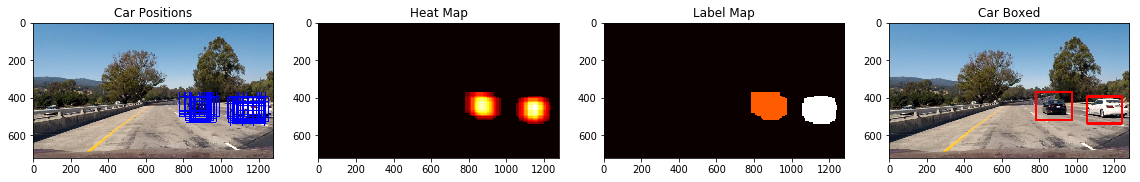

test1
Max: 0.0
Number of windows: 0


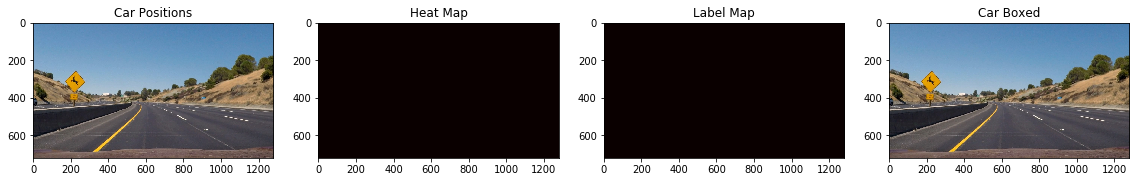

test2
Max: 3.0
Number of windows: 3


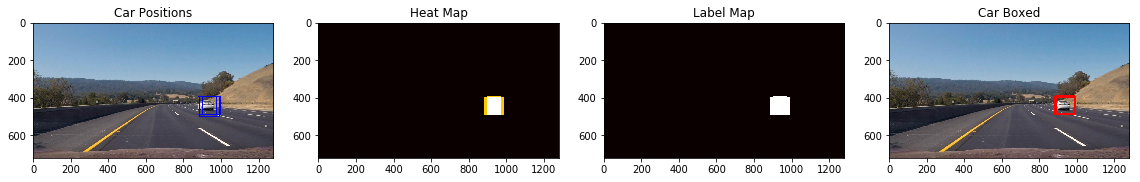

test3
Max: 35.0
Number of windows: 74


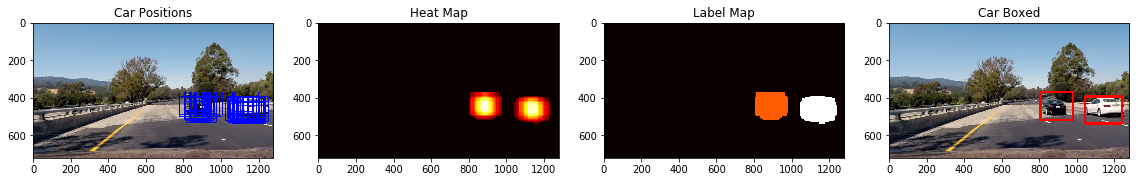

test4
Max: 34.0
Number of windows: 51


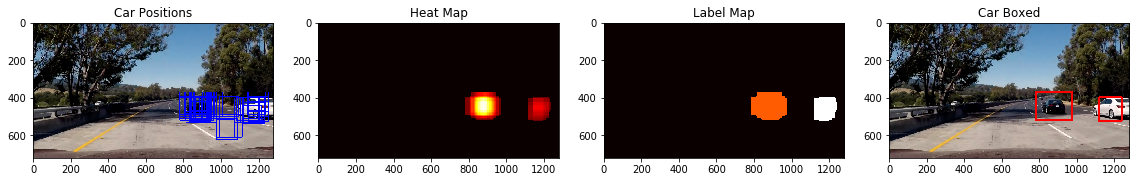

test5
Max: 32.0
Number of windows: 69


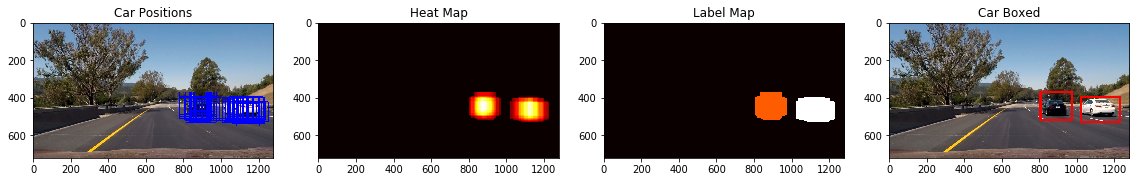

Finished testing!
Window: 64
Using 27.249300003051758 seconds for 6 images.


In [19]:
x_start_stop = [780, None]     # Min and max in x to search in slide_window()
y_start_stop = [370, 650]      # Min and max in y to search in slide_window()
wsize = round(64)
xy_window = (wsize, wsize)
heat_thr = [1, 4]
scales = np.linspace(1.5, 2, 5)

image_flag = True
plot_flag = True
test_images = glob.glob('test_images/test*.jpg')
t1 = time.time()

if image_flag:
    # single image test
    for i in range(0, len(test_images)):
        print('test' + str(i))
        image_name = test_images[i]
        #print(image_name)
        image = mpimg.imread(image_name)
        
        find_cars(image, y_start_stop, x_start_stop, 
                  scales, svc, X_scaler, 
                  orient, pix_per_cell, 
                  cell_per_block, spatial_size, hist_bins, wsize, heat_thr,  plot_flag)
    print("Finished testing!")
    t2 = time.time()
    print("Window: "+ str(wsize))
    print("Using "+str(t2-t1)+" seconds for "+ str(len(test_images)) + " images.")

## Video Processing

In [11]:
heat_hist = []
video_plot_flag = False
heat_thr = [2, 7]
max_frame = 1

def process_video(img,y_start_stop = y_start_stop, x_start_stop = x_start_stop, scales = scales, svc = svc, 
                  X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell, 
                  cell_per_block = cell_per_block, spatial_size = spatial_size, hist_bins = hist_bins, 
                  window = wsize, heat_thr = heat_thr, plot_flag=video_plot_flag):
    
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    xstart = x_start_stop[0]
    xstop = x_start_stop[1]
    
    draw_img = np.copy(img)  # for original window
    final_img = np.copy(img) # for combined window

    img = img.astype(np.float32)/np.max(img)
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    hot_windows = []
    for scale in scales:
        #print(scale)
        hot_window_scale, draw_img = label_window(xstart, xstop, ystart, ystop,
                               ctrans_tosearch, final_img, draw_img,
                               orient, pix_per_cell, cell_per_block,
                               window, spatial_size,hist_bins, scale)
        hot_windows = hot_windows + hot_window_scale
    # draw hot windows on image
    #cv2.rectangle(draw_img,(startx, starty),(endx, endy),(0,0,255),6) 
                
    heat = np.zeros_like(final_img[:,:,0]).astype(np.float64)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    global heat_hist
    heat_hist.append(heat)
    
    current_heat = np.mean(heat_hist, axis=0)
    # average across max_frame 
    if len(heat_hist) > max_frame:
        heat_hist.pop(0)
                         
    # store current_heat to history
    heat_hist[len(heat_hist)-1] = tuple(heat)
    
    # Apply threshold to help remove false positives
    if np.max(current_heat) < 30:
        heat_thred = apply_threshold(current_heat, heat_thr[0])
    else:
        heat_thred = apply_threshold(current_heat, heat_thr[1])

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thred, 0, 255)
    

    # Find final boxes from eatmap using label function
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(final_img, labels)
    
    if plot_flag:
        print('Number of windows: ' + str(len(hot_windows)))
        print('Heat Map Max Point: '+ str(np.max(heat_thred)))
        fig = plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(133)
        plt.imshow(final_img)
        plt.title('Car Boxed')
        fig.tight_layout()
        plt.show()
                         
    return final_img

In [12]:
test_flag = False
if test_flag:
    # process test video
    from moviepy.editor import VideoFileClip
    # process video images
    clip1 = VideoFileClip("test_video.mp4")
    white_clip = clip1.fl_image(process_image)
    
    video_output = 'test_output_.mp4'
    %time white_clip.write_videofile(video_output, audio=False)

In [13]:
# process project video
from moviepy.editor import VideoFileClip
clip_flag = False

if clip_flag:
    sec1 = 49.5
    sec2 = 50.5
    clip1 = VideoFileClip("project_video.mp4").subclip(sec1, sec2)
    white_clip = clip1.fl_image(process_video)
    video_output = 'project_output_' + str(sec1) + '_'+ str(sec2) + \
    '_' + str(max_frame) + '_' + str(heat_thr) + '_multiscale.mp4'
else:
    clip1 = VideoFileClip("project_video.mp4") 
    white_clip = clip1.fl_image(process_video) 
    video_output = 'project_output_multiscale_' + str(max_frame) +\
    '_' + str(heat_thr) +'frame.mp4'
    
%time white_clip.write_videofile(video_output, audio=False)

Max: 1.0
[MoviePy] >>>> Building video project_output_multiscale_1_[2, 7]frame.mp4
[MoviePy] Writing video project_output_multiscale_1_[2, 7]frame.mp4


  0%|          | 1/1261 [00:03<1:11:07,  3.39s/it]

Max: 1.0


  0%|          | 2/1261 [00:06<1:10:25,  3.36s/it]

Max: 1.0


  0%|          | 3/1261 [00:10<1:13:04,  3.49s/it]

Max: 0.0


  0%|          | 4/1261 [00:13<1:12:14,  3.45s/it]

Max: 0.0


  0%|          | 5/1261 [00:17<1:14:03,  3.54s/it]

Max: 1.0


  0%|          | 6/1261 [00:21<1:13:43,  3.52s/it]

Max: 4.0


  1%|          | 7/1261 [00:24<1:15:05,  3.59s/it]

Max: 5.0


  1%|          | 8/1261 [00:28<1:15:17,  3.60s/it]

Max: 1.0


  1%|          | 9/1261 [00:31<1:14:27,  3.57s/it]

Max: 0.0


  1%|          | 10/1261 [00:35<1:15:03,  3.60s/it]

Max: 3.0


  1%|          | 11/1261 [00:39<1:15:42,  3.63s/it]

Max: 1.0


  1%|          | 12/1261 [00:43<1:16:26,  3.67s/it]

Max: 0.0


  1%|          | 13/1261 [00:46<1:15:34,  3.63s/it]

Max: 0.0


  1%|          | 14/1261 [00:50<1:15:29,  3.63s/it]

Max: 1.0


  1%|          | 15/1261 [00:53<1:15:51,  3.65s/it]

Max: 1.0


  1%|▏         | 16/1261 [00:57<1:15:23,  3.63s/it]

Max: 0.0


  1%|▏         | 17/1261 [01:01<1:15:36,  3.65s/it]

Max: 0.0


  1%|▏         | 18/1261 [01:04<1:15:31,  3.65s/it]

Max: 0.0


  2%|▏         | 19/1261 [01:08<1:14:00,  3.58s/it]

Max: 0.0


  2%|▏         | 20/1261 [01:11<1:12:50,  3.52s/it]

Max: 0.0


  2%|▏         | 21/1261 [01:15<1:12:05,  3.49s/it]

Max: 0.0


  2%|▏         | 22/1261 [01:18<1:11:07,  3.44s/it]

Max: 1.0


  2%|▏         | 23/1261 [01:21<1:10:56,  3.44s/it]

Max: 0.0


  2%|▏         | 24/1261 [01:25<1:10:26,  3.42s/it]

Max: 1.0


  2%|▏         | 25/1261 [01:28<1:11:09,  3.45s/it]

Max: 0.0


  2%|▏         | 26/1261 [01:32<1:10:28,  3.42s/it]

Max: 1.0


  2%|▏         | 27/1261 [01:35<1:10:19,  3.42s/it]

Max: 0.0


  2%|▏         | 28/1261 [01:38<1:09:35,  3.39s/it]

Max: 2.0


  2%|▏         | 29/1261 [01:42<1:09:42,  3.39s/it]

Max: 0.0


  2%|▏         | 30/1261 [01:45<1:09:23,  3.38s/it]

Max: 1.0


  2%|▏         | 31/1261 [01:48<1:08:35,  3.35s/it]

Max: 0.0


  3%|▎         | 32/1261 [01:52<1:08:57,  3.37s/it]

Max: 2.0


  3%|▎         | 33/1261 [01:55<1:08:06,  3.33s/it]

Max: 2.0


  3%|▎         | 34/1261 [01:58<1:08:06,  3.33s/it]

Max: 0.0


  3%|▎         | 35/1261 [02:01<1:06:53,  3.27s/it]

Max: 2.0


  3%|▎         | 36/1261 [02:05<1:08:21,  3.35s/it]

Max: 0.0


  3%|▎         | 37/1261 [02:09<1:09:29,  3.41s/it]

Max: 0.0


  3%|▎         | 38/1261 [02:12<1:09:25,  3.41s/it]

Max: 0.0


  3%|▎         | 39/1261 [02:15<1:09:16,  3.40s/it]

Max: 4.0


  3%|▎         | 40/1261 [02:19<1:08:07,  3.35s/it]

Max: 0.0


  3%|▎         | 41/1261 [02:22<1:10:12,  3.45s/it]

Max: 1.0


  3%|▎         | 42/1261 [02:26<1:13:18,  3.61s/it]

Max: 0.0


  3%|▎         | 43/1261 [02:30<1:14:37,  3.68s/it]

Max: 0.0


  3%|▎         | 44/1261 [02:34<1:15:56,  3.74s/it]

Max: 0.0


  4%|▎         | 45/1261 [02:38<1:18:02,  3.85s/it]

Max: 1.0


  4%|▎         | 46/1261 [02:42<1:19:55,  3.95s/it]

Max: 1.0


  4%|▎         | 47/1261 [02:46<1:20:09,  3.96s/it]

Max: 0.0


  4%|▍         | 48/1261 [02:50<1:19:44,  3.94s/it]

Max: 1.0


  4%|▍         | 49/1261 [02:54<1:20:16,  3.97s/it]

Max: 1.0


  4%|▍         | 50/1261 [02:58<1:19:17,  3.93s/it]

Max: 0.0


  4%|▍         | 51/1261 [03:02<1:18:45,  3.91s/it]

Max: 0.0


  4%|▍         | 52/1261 [03:06<1:17:37,  3.85s/it]

Max: 1.0


  4%|▍         | 53/1261 [03:09<1:17:04,  3.83s/it]

Max: 1.0


  4%|▍         | 54/1261 [03:13<1:16:26,  3.80s/it]

Max: 4.0


  4%|▍         | 55/1261 [03:17<1:14:03,  3.68s/it]

Max: 0.0


  4%|▍         | 56/1261 [03:20<1:10:51,  3.53s/it]

Max: 3.0


  5%|▍         | 57/1261 [03:23<1:09:00,  3.44s/it]

Max: 2.0


  5%|▍         | 58/1261 [03:26<1:07:12,  3.35s/it]

Max: 0.0


  5%|▍         | 59/1261 [03:29<1:06:16,  3.31s/it]

Max: 1.0


  5%|▍         | 60/1261 [03:33<1:07:14,  3.36s/it]

Max: 1.0


  5%|▍         | 61/1261 [03:36<1:07:32,  3.38s/it]

Max: 0.0


  5%|▍         | 62/1261 [03:39<1:06:50,  3.34s/it]

Max: 0.0


  5%|▍         | 63/1261 [03:43<1:06:53,  3.35s/it]

Max: 0.0


  5%|▌         | 64/1261 [03:46<1:05:30,  3.28s/it]

Max: 0.0


  5%|▌         | 65/1261 [03:49<1:06:12,  3.32s/it]

Max: 1.0


  5%|▌         | 66/1261 [03:53<1:07:30,  3.39s/it]

Max: 3.0


  5%|▌         | 67/1261 [03:56<1:08:32,  3.44s/it]

Max: 1.0


  5%|▌         | 68/1261 [04:00<1:07:13,  3.38s/it]

Max: 0.0


  5%|▌         | 69/1261 [04:03<1:06:08,  3.33s/it]

Max: 0.0


  6%|▌         | 70/1261 [04:06<1:05:23,  3.29s/it]

Max: 0.0


  6%|▌         | 71/1261 [04:09<1:04:45,  3.27s/it]

Max: 0.0


  6%|▌         | 72/1261 [04:13<1:04:49,  3.27s/it]

Max: 0.0


  6%|▌         | 73/1261 [04:16<1:04:04,  3.24s/it]

Max: 0.0


  6%|▌         | 74/1261 [04:19<1:03:55,  3.23s/it]

Max: 0.0


  6%|▌         | 75/1261 [04:22<1:03:53,  3.23s/it]

Max: 0.0


  6%|▌         | 76/1261 [04:25<1:03:31,  3.22s/it]

Max: 3.0


  6%|▌         | 77/1261 [04:29<1:03:13,  3.20s/it]

Max: 1.0


  6%|▌         | 78/1261 [04:32<1:03:13,  3.21s/it]

Max: 0.0


  6%|▋         | 79/1261 [04:35<1:03:21,  3.22s/it]

Max: 0.0


  6%|▋         | 80/1261 [04:38<1:03:11,  3.21s/it]

Max: 0.0


  6%|▋         | 81/1261 [04:41<1:03:24,  3.22s/it]

Max: 0.0


  7%|▋         | 82/1261 [04:45<1:03:26,  3.23s/it]

Max: 1.0


  7%|▋         | 83/1261 [04:48<1:03:05,  3.21s/it]

Max: 0.0


  7%|▋         | 84/1261 [04:51<1:02:47,  3.20s/it]

Max: 1.0


  7%|▋         | 85/1261 [04:54<1:02:40,  3.20s/it]

Max: 0.0


  7%|▋         | 86/1261 [04:57<1:02:38,  3.20s/it]

Max: 1.0


  7%|▋         | 87/1261 [05:01<1:02:59,  3.22s/it]

Max: 0.0


  7%|▋         | 88/1261 [05:04<1:02:54,  3.22s/it]

Max: 0.0


  7%|▋         | 89/1261 [05:07<1:02:29,  3.20s/it]

Max: 0.0


  7%|▋         | 90/1261 [05:10<1:02:19,  3.19s/it]

Max: 0.0


  7%|▋         | 91/1261 [05:13<1:02:14,  3.19s/it]

Max: 0.0


  7%|▋         | 92/1261 [05:17<1:01:50,  3.17s/it]

Max: 2.0


  7%|▋         | 93/1261 [05:20<1:01:28,  3.16s/it]

Max: 1.0


  7%|▋         | 94/1261 [05:23<1:01:49,  3.18s/it]

Max: 0.0


  8%|▊         | 95/1261 [05:26<1:01:46,  3.18s/it]

Max: 0.0


  8%|▊         | 96/1261 [05:29<1:01:41,  3.18s/it]

Max: 0.0


  8%|▊         | 97/1261 [05:32<1:01:22,  3.16s/it]

Max: 0.0


  8%|▊         | 98/1261 [05:36<1:01:12,  3.16s/it]

Max: 0.0


  8%|▊         | 99/1261 [05:39<1:01:11,  3.16s/it]

Max: 0.0


  8%|▊         | 100/1261 [05:42<1:01:04,  3.16s/it]

Max: 0.0


  8%|▊         | 101/1261 [05:45<1:01:18,  3.17s/it]

Max: 0.0


  8%|▊         | 102/1261 [05:48<1:00:57,  3.16s/it]

Max: 0.0


  8%|▊         | 103/1261 [05:51<1:01:01,  3.16s/it]

Max: 1.0


  8%|▊         | 104/1261 [05:55<1:00:59,  3.16s/it]

Max: 1.0


  8%|▊         | 105/1261 [05:58<1:00:52,  3.16s/it]

Max: 0.0


  8%|▊         | 106/1261 [06:01<1:00:58,  3.17s/it]

Max: 1.0


  8%|▊         | 107/1261 [06:04<1:01:54,  3.22s/it]

Max: 0.0


  9%|▊         | 108/1261 [06:08<1:03:12,  3.29s/it]

Max: 0.0


  9%|▊         | 109/1261 [06:11<1:02:31,  3.26s/it]

Max: 1.0


  9%|▊         | 110/1261 [06:14<1:03:08,  3.29s/it]

Max: 0.0


  9%|▉         | 111/1261 [06:18<1:04:09,  3.35s/it]

Max: 0.0


  9%|▉         | 112/1261 [06:21<1:03:19,  3.31s/it]

Max: 0.0


  9%|▉         | 113/1261 [06:24<1:02:23,  3.26s/it]

Max: 0.0


  9%|▉         | 114/1261 [06:27<1:02:35,  3.27s/it]

Max: 0.0


  9%|▉         | 115/1261 [06:31<1:03:06,  3.30s/it]

Max: 1.0


  9%|▉         | 116/1261 [06:34<1:02:28,  3.27s/it]

Max: 2.0


  9%|▉         | 117/1261 [06:37<1:01:50,  3.24s/it]

Max: 0.0


  9%|▉         | 118/1261 [06:40<1:01:08,  3.21s/it]

Max: 1.0


  9%|▉         | 119/1261 [06:44<1:01:33,  3.23s/it]

Max: 1.0


 10%|▉         | 120/1261 [06:47<1:01:55,  3.26s/it]

Max: 0.0


 10%|▉         | 121/1261 [06:50<1:01:56,  3.26s/it]

Max: 1.0


 10%|▉         | 122/1261 [06:53<1:01:05,  3.22s/it]

Max: 1.0


 10%|▉         | 123/1261 [06:56<1:00:29,  3.19s/it]

Max: 1.0


 10%|▉         | 124/1261 [07:00<1:00:18,  3.18s/it]

Max: 0.0


 10%|▉         | 125/1261 [07:03<1:00:12,  3.18s/it]

Max: 0.0


 10%|▉         | 126/1261 [07:06<59:50,  3.16s/it]  

Max: 0.0


 10%|█         | 127/1261 [07:09<59:53,  3.17s/it]

Max: 0.0


 10%|█         | 128/1261 [07:12<1:00:01,  3.18s/it]

Max: 0.0


 10%|█         | 129/1261 [07:15<59:49,  3.17s/it]  

Max: 0.0


 10%|█         | 130/1261 [07:19<59:49,  3.17s/it]

Max: 1.0


 10%|█         | 131/1261 [07:22<59:49,  3.18s/it]

Max: 0.0


 10%|█         | 132/1261 [07:25<59:54,  3.18s/it]

Max: 0.0


 11%|█         | 133/1261 [07:28<59:40,  3.17s/it]

Max: 0.0


 11%|█         | 134/1261 [07:31<59:33,  3.17s/it]

Max: 0.0


 11%|█         | 135/1261 [07:34<59:38,  3.18s/it]

Max: 0.0


 11%|█         | 136/1261 [07:38<59:59,  3.20s/it]

Max: 0.0


 11%|█         | 137/1261 [07:41<1:00:25,  3.23s/it]

Max: 1.0


 11%|█         | 138/1261 [07:44<1:00:52,  3.25s/it]

Max: 0.0


 11%|█         | 139/1261 [07:47<1:00:32,  3.24s/it]

Max: 1.0


 11%|█         | 140/1261 [07:51<1:00:13,  3.22s/it]

Max: 1.0


 11%|█         | 141/1261 [07:54<1:00:01,  3.22s/it]

Max: 0.0


 11%|█▏        | 142/1261 [07:57<59:32,  3.19s/it]  

Max: 0.0


 11%|█▏        | 143/1261 [08:00<59:32,  3.20s/it]

Max: 1.0


 11%|█▏        | 144/1261 [08:04<1:00:09,  3.23s/it]

Max: 0.0


 11%|█▏        | 145/1261 [08:07<1:00:17,  3.24s/it]

Max: 0.0


 12%|█▏        | 146/1261 [08:10<1:00:33,  3.26s/it]

Max: 0.0


 12%|█▏        | 147/1261 [08:13<1:00:49,  3.28s/it]

Max: 0.0


 12%|█▏        | 148/1261 [08:17<1:00:56,  3.29s/it]

Max: 0.0


 12%|█▏        | 149/1261 [08:20<1:02:04,  3.35s/it]

Max: 0.0


 12%|█▏        | 150/1261 [08:23<1:01:08,  3.30s/it]

Max: 0.0


 12%|█▏        | 151/1261 [08:27<1:00:09,  3.25s/it]

Max: 0.0


 12%|█▏        | 152/1261 [08:30<59:49,  3.24s/it]  

Max: 2.0


 12%|█▏        | 153/1261 [08:33<59:40,  3.23s/it]

Max: 1.0


 12%|█▏        | 154/1261 [08:36<59:33,  3.23s/it]

Max: 1.0


 12%|█▏        | 155/1261 [08:39<59:19,  3.22s/it]

Max: 0.0


 12%|█▏        | 156/1261 [08:43<59:09,  3.21s/it]

Max: 2.0


 12%|█▏        | 157/1261 [08:46<58:32,  3.18s/it]

Max: 0.0


 13%|█▎        | 158/1261 [08:49<58:28,  3.18s/it]

Max: 1.0


 13%|█▎        | 159/1261 [08:52<58:14,  3.17s/it]

Max: 0.0


 13%|█▎        | 160/1261 [08:55<58:16,  3.18s/it]

Max: 0.0


 13%|█▎        | 161/1261 [08:58<58:37,  3.20s/it]

Max: 2.0


 13%|█▎        | 162/1261 [09:02<58:41,  3.20s/it]

Max: 1.0


 13%|█▎        | 163/1261 [09:05<59:06,  3.23s/it]

Max: 2.0


 13%|█▎        | 164/1261 [09:08<58:52,  3.22s/it]

Max: 3.0


 13%|█▎        | 165/1261 [09:11<58:55,  3.23s/it]

Max: 1.0


 13%|█▎        | 166/1261 [09:15<58:37,  3.21s/it]

Max: 3.0


 13%|█▎        | 167/1261 [09:18<58:28,  3.21s/it]

Max: 3.0


 13%|█▎        | 168/1261 [09:21<58:18,  3.20s/it]

Max: 6.0


 13%|█▎        | 169/1261 [09:24<58:14,  3.20s/it]

Max: 6.0


 13%|█▎        | 170/1261 [09:27<58:01,  3.19s/it]

Max: 9.0


 14%|█▎        | 171/1261 [09:30<57:50,  3.18s/it]

Max: 9.0


 14%|█▎        | 172/1261 [09:34<58:08,  3.20s/it]

Max: 6.0


 14%|█▎        | 173/1261 [09:37<57:57,  3.20s/it]

Max: 7.0


 14%|█▍        | 174/1261 [09:40<58:24,  3.22s/it]

Max: 11.0


 14%|█▍        | 175/1261 [09:44<58:52,  3.25s/it]

Max: 13.0


 14%|█▍        | 176/1261 [09:47<59:20,  3.28s/it]

Max: 12.0


 14%|█▍        | 177/1261 [09:50<59:02,  3.27s/it]

Max: 11.0


 14%|█▍        | 178/1261 [09:53<58:38,  3.25s/it]

Max: 11.0


 14%|█▍        | 179/1261 [09:57<58:23,  3.24s/it]

Max: 10.0


 14%|█▍        | 180/1261 [10:00<58:13,  3.23s/it]

Max: 14.0


 14%|█▍        | 181/1261 [10:03<58:21,  3.24s/it]

Max: 18.0


 14%|█▍        | 182/1261 [10:06<58:33,  3.26s/it]

Max: 15.0


 15%|█▍        | 183/1261 [10:10<59:13,  3.30s/it]

Max: 15.0


 15%|█▍        | 184/1261 [10:13<1:00:46,  3.39s/it]

Max: 15.0


 15%|█▍        | 185/1261 [10:17<1:00:07,  3.35s/it]

Max: 16.0


 15%|█▍        | 186/1261 [10:20<1:00:40,  3.39s/it]

Max: 17.0


 15%|█▍        | 187/1261 [10:23<1:00:43,  3.39s/it]

Max: 20.0


 15%|█▍        | 188/1261 [10:27<1:00:40,  3.39s/it]

Max: 20.0


 15%|█▍        | 189/1261 [10:30<1:00:38,  3.39s/it]

Max: 17.0


 15%|█▌        | 190/1261 [10:34<1:00:14,  3.38s/it]

Max: 16.0


 15%|█▌        | 191/1261 [10:37<58:52,  3.30s/it]  

Max: 15.0


 15%|█▌        | 192/1261 [10:40<58:07,  3.26s/it]

Max: 12.0


 15%|█▌        | 193/1261 [10:43<57:39,  3.24s/it]

Max: 20.0


 15%|█▌        | 194/1261 [10:46<56:59,  3.20s/it]

Max: 17.0


 15%|█▌        | 195/1261 [10:50<58:36,  3.30s/it]

Max: 20.0


 16%|█▌        | 196/1261 [10:53<59:42,  3.36s/it]

Max: 18.0


 16%|█▌        | 197/1261 [10:57<1:00:45,  3.43s/it]

Max: 23.0


 16%|█▌        | 198/1261 [11:00<1:00:45,  3.43s/it]

Max: 22.0


 16%|█▌        | 199/1261 [11:03<59:58,  3.39s/it]  

Max: 20.0


 16%|█▌        | 200/1261 [11:07<59:49,  3.38s/it]

Max: 23.0


 16%|█▌        | 201/1261 [11:10<1:01:05,  3.46s/it]

Max: 19.0


 16%|█▌        | 202/1261 [11:14<1:00:55,  3.45s/it]

Max: 23.0


 16%|█▌        | 203/1261 [11:17<58:55,  3.34s/it]  

Max: 25.0


 16%|█▌        | 204/1261 [11:20<58:56,  3.35s/it]

Max: 26.0


 16%|█▋        | 205/1261 [11:24<58:43,  3.34s/it]

Max: 25.0


 16%|█▋        | 206/1261 [11:27<59:03,  3.36s/it]

Max: 25.0


 16%|█▋        | 207/1261 [11:31<1:00:09,  3.42s/it]

Max: 25.0


 16%|█▋        | 208/1261 [11:34<1:00:12,  3.43s/it]

Max: 25.0


 17%|█▋        | 209/1261 [11:38<59:54,  3.42s/it]  

Max: 25.0


 17%|█▋        | 210/1261 [11:41<59:06,  3.37s/it]

Max: 28.0


 17%|█▋        | 211/1261 [11:44<58:20,  3.33s/it]

Max: 19.0


 17%|█▋        | 212/1261 [11:47<58:20,  3.34s/it]

Max: 18.0


 17%|█▋        | 213/1261 [11:51<58:13,  3.33s/it]

Max: 20.0


 17%|█▋        | 214/1261 [11:54<58:19,  3.34s/it]

Max: 27.0


 17%|█▋        | 215/1261 [11:57<58:11,  3.34s/it]

Max: 29.0


 17%|█▋        | 216/1261 [12:01<58:08,  3.34s/it]

Max: 35.0


 17%|█▋        | 217/1261 [12:04<57:59,  3.33s/it]

Max: 33.0


 17%|█▋        | 218/1261 [12:07<58:04,  3.34s/it]

Max: 30.0


 17%|█▋        | 219/1261 [12:11<58:15,  3.35s/it]

Max: 34.0


 17%|█▋        | 220/1261 [12:14<58:32,  3.37s/it]

Max: 31.0


 18%|█▊        | 221/1261 [12:18<59:14,  3.42s/it]

Max: 31.0


 18%|█▊        | 222/1261 [12:21<59:14,  3.42s/it]

Max: 28.0


 18%|█▊        | 223/1261 [12:25<59:14,  3.42s/it]

Max: 30.0


 18%|█▊        | 224/1261 [12:28<58:42,  3.40s/it]

Max: 28.0


 18%|█▊        | 225/1261 [12:31<58:10,  3.37s/it]

Max: 31.0


 18%|█▊        | 226/1261 [12:35<57:53,  3.36s/it]

Max: 31.0


 18%|█▊        | 227/1261 [12:38<57:41,  3.35s/it]

Max: 33.0


 18%|█▊        | 228/1261 [12:41<57:35,  3.35s/it]

Max: 33.0


 18%|█▊        | 229/1261 [12:45<57:18,  3.33s/it]

Max: 34.0


 18%|█▊        | 230/1261 [12:48<57:22,  3.34s/it]

Max: 35.0


 18%|█▊        | 231/1261 [12:51<57:16,  3.34s/it]

Max: 32.0


 18%|█▊        | 232/1261 [12:54<56:59,  3.32s/it]

Max: 31.0


 18%|█▊        | 233/1261 [12:58<55:56,  3.27s/it]

Max: 32.0


 19%|█▊        | 234/1261 [13:01<55:24,  3.24s/it]

Max: 34.0


 19%|█▊        | 235/1261 [13:04<55:00,  3.22s/it]

Max: 32.0


 19%|█▊        | 236/1261 [13:07<54:39,  3.20s/it]

Max: 33.0


 19%|█▉        | 237/1261 [13:10<54:23,  3.19s/it]

Max: 32.0


 19%|█▉        | 238/1261 [13:13<54:19,  3.19s/it]

Max: 32.0


 19%|█▉        | 239/1261 [13:17<53:56,  3.17s/it]

Max: 33.0


 19%|█▉        | 240/1261 [13:20<53:42,  3.16s/it]

Max: 35.0


 19%|█▉        | 241/1261 [13:23<53:43,  3.16s/it]

Max: 30.0


 19%|█▉        | 242/1261 [13:26<53:21,  3.14s/it]

Max: 30.0


 19%|█▉        | 243/1261 [13:29<53:05,  3.13s/it]

Max: 31.0


 19%|█▉        | 244/1261 [13:32<53:05,  3.13s/it]

Max: 29.0


 19%|█▉        | 245/1261 [13:35<53:06,  3.14s/it]

Max: 31.0


 20%|█▉        | 246/1261 [13:39<53:02,  3.14s/it]

Max: 35.0


 20%|█▉        | 247/1261 [13:42<53:05,  3.14s/it]

Max: 29.0


 20%|█▉        | 248/1261 [13:45<52:54,  3.13s/it]

Max: 31.0


 20%|█▉        | 249/1261 [13:48<52:47,  3.13s/it]

Max: 31.0


 20%|█▉        | 250/1261 [13:51<52:49,  3.14s/it]

Max: 32.0


 20%|█▉        | 251/1261 [13:54<52:48,  3.14s/it]

Max: 33.0


 20%|█▉        | 252/1261 [13:57<52:39,  3.13s/it]

Max: 36.0


 20%|██        | 253/1261 [14:00<52:42,  3.14s/it]

Max: 35.0


 20%|██        | 254/1261 [14:04<52:46,  3.14s/it]

Max: 35.0


 20%|██        | 255/1261 [14:07<53:04,  3.17s/it]

Max: 34.0


 20%|██        | 256/1261 [14:10<53:37,  3.20s/it]

Max: 31.0


 20%|██        | 257/1261 [14:13<53:38,  3.21s/it]

Max: 30.0


 20%|██        | 258/1261 [14:17<53:25,  3.20s/it]

Max: 31.0


 21%|██        | 259/1261 [14:20<53:13,  3.19s/it]

Max: 33.0


 21%|██        | 260/1261 [14:23<53:06,  3.18s/it]

Max: 34.0


 21%|██        | 261/1261 [14:26<53:00,  3.18s/it]

Max: 32.0


 21%|██        | 262/1261 [14:29<52:41,  3.16s/it]

Max: 31.0


 21%|██        | 263/1261 [14:32<52:44,  3.17s/it]

Max: 32.0


 21%|██        | 264/1261 [14:35<52:29,  3.16s/it]

Max: 31.0


 21%|██        | 265/1261 [14:39<52:25,  3.16s/it]

Max: 30.0


 21%|██        | 266/1261 [14:42<52:22,  3.16s/it]

Max: 30.0


 21%|██        | 267/1261 [14:45<52:11,  3.15s/it]

Max: 30.0


 21%|██▏       | 268/1261 [14:48<52:08,  3.15s/it]

Max: 30.0


 21%|██▏       | 269/1261 [14:51<52:07,  3.15s/it]

Max: 30.0


 21%|██▏       | 270/1261 [14:54<52:07,  3.16s/it]

Max: 28.0


 21%|██▏       | 271/1261 [14:57<51:47,  3.14s/it]

Max: 30.0


 22%|██▏       | 272/1261 [15:01<51:46,  3.14s/it]

Max: 33.0


 22%|██▏       | 273/1261 [15:04<51:33,  3.13s/it]

Max: 34.0


 22%|██▏       | 274/1261 [15:07<51:32,  3.13s/it]

Max: 37.0


 22%|██▏       | 275/1261 [15:10<51:38,  3.14s/it]

Max: 38.0


 22%|██▏       | 276/1261 [15:13<51:50,  3.16s/it]

Max: 37.0


 22%|██▏       | 277/1261 [15:16<51:41,  3.15s/it]

Max: 36.0


 22%|██▏       | 278/1261 [15:20<51:31,  3.14s/it]

Max: 36.0


 22%|██▏       | 279/1261 [15:23<51:48,  3.17s/it]

Max: 37.0


 22%|██▏       | 280/1261 [15:26<51:42,  3.16s/it]

Max: 38.0


 22%|██▏       | 281/1261 [15:29<51:29,  3.15s/it]

Max: 36.0


 22%|██▏       | 282/1261 [15:32<51:26,  3.15s/it]

Max: 36.0


 22%|██▏       | 283/1261 [15:35<51:14,  3.14s/it]

Max: 35.0


 23%|██▎       | 284/1261 [15:38<51:01,  3.13s/it]

Max: 36.0


 23%|██▎       | 285/1261 [15:42<51:09,  3.14s/it]

Max: 35.0


 23%|██▎       | 286/1261 [15:45<50:55,  3.13s/it]

Max: 36.0


 23%|██▎       | 287/1261 [15:48<50:54,  3.14s/it]

Max: 37.0


 23%|██▎       | 288/1261 [15:51<50:47,  3.13s/it]

Max: 35.0


 23%|██▎       | 289/1261 [15:54<50:55,  3.14s/it]

Max: 37.0


 23%|██▎       | 290/1261 [15:57<50:51,  3.14s/it]

Max: 37.0


 23%|██▎       | 291/1261 [16:00<50:47,  3.14s/it]

Max: 37.0


 23%|██▎       | 292/1261 [16:04<50:57,  3.15s/it]

Max: 37.0


 23%|██▎       | 293/1261 [16:07<51:07,  3.17s/it]

Max: 36.0


 23%|██▎       | 294/1261 [16:10<51:31,  3.20s/it]

Max: 33.0


 23%|██▎       | 295/1261 [16:13<51:52,  3.22s/it]

Max: 35.0


 23%|██▎       | 296/1261 [16:17<52:23,  3.26s/it]

Max: 32.0


 24%|██▎       | 297/1261 [16:20<51:04,  3.18s/it]

Max: 36.0


 24%|██▎       | 298/1261 [16:23<50:03,  3.12s/it]

Max: 38.0


 24%|██▎       | 299/1261 [16:26<49:13,  3.07s/it]

Max: 38.0


 24%|██▍       | 300/1261 [16:29<48:48,  3.05s/it]

Max: 36.0


 24%|██▍       | 301/1261 [16:32<49:12,  3.08s/it]

Max: 39.0


 24%|██▍       | 302/1261 [17:06<3:18:20, 12.41s/it]

Max: 38.0


 24%|██▍       | 303/1261 [17:10<2:37:26,  9.86s/it]

Max: 36.0


 24%|██▍       | 304/1261 [17:14<2:07:53,  8.02s/it]

Max: 35.0


 24%|██▍       | 305/1261 [17:17<1:46:47,  6.70s/it]

Max: 38.0


 24%|██▍       | 306/1261 [17:21<1:32:27,  5.81s/it]

Max: 36.0


 24%|██▍       | 307/1261 [17:24<1:21:34,  5.13s/it]

Max: 35.0


 24%|██▍       | 308/1261 [17:28<1:11:45,  4.52s/it]

Max: 33.0


 25%|██▍       | 309/1261 [17:31<1:04:25,  4.06s/it]

Max: 36.0


 25%|██▍       | 310/1261 [17:34<1:00:22,  3.81s/it]

Max: 35.0


 25%|██▍       | 311/1261 [17:37<57:32,  3.63s/it]  

Max: 37.0


 25%|██▍       | 312/1261 [17:40<55:51,  3.53s/it]

Max: 37.0


 25%|██▍       | 313/1261 [17:44<55:24,  3.51s/it]

Max: 36.0


 25%|██▍       | 314/1261 [17:47<54:35,  3.46s/it]

Max: 33.0


 25%|██▍       | 315/1261 [17:50<53:21,  3.38s/it]

Max: 34.0


 25%|██▌       | 316/1261 [17:53<52:21,  3.32s/it]

Max: 32.0


 25%|██▌       | 317/1261 [17:57<51:57,  3.30s/it]

Max: 34.0


 25%|██▌       | 318/1261 [18:00<51:06,  3.25s/it]

Max: 31.0


 25%|██▌       | 319/1261 [18:03<49:54,  3.18s/it]

Max: 32.0


 25%|██▌       | 320/1261 [18:06<48:55,  3.12s/it]

Max: 32.0


 25%|██▌       | 321/1261 [18:09<48:45,  3.11s/it]

Max: 34.0


 26%|██▌       | 322/1261 [18:12<48:46,  3.12s/it]

Max: 34.0


 26%|██▌       | 323/1261 [18:15<49:24,  3.16s/it]

Max: 34.0


 26%|██▌       | 324/1261 [18:19<49:56,  3.20s/it]

Max: 34.0


 26%|██▌       | 325/1261 [18:22<51:32,  3.30s/it]

Max: 35.0


 26%|██▌       | 326/1261 [18:25<51:33,  3.31s/it]

Max: 33.0


 26%|██▌       | 327/1261 [18:29<51:55,  3.34s/it]

Max: 31.0


 26%|██▌       | 328/1261 [18:33<53:36,  3.45s/it]

Max: 34.0


 26%|██▌       | 329/1261 [18:37<57:10,  3.68s/it]

Max: 33.0


 26%|██▌       | 330/1261 [18:40<56:59,  3.67s/it]

Max: 31.0


 26%|██▌       | 331/1261 [18:44<54:13,  3.50s/it]

Max: 31.0


 26%|██▋       | 332/1261 [18:47<51:51,  3.35s/it]

Max: 30.0


 26%|██▋       | 333/1261 [18:50<50:13,  3.25s/it]

Max: 32.0


 26%|██▋       | 334/1261 [18:53<49:23,  3.20s/it]

Max: 32.0


 27%|██▋       | 335/1261 [18:56<49:28,  3.21s/it]

Max: 34.0


 27%|██▋       | 336/1261 [18:59<48:59,  3.18s/it]

Max: 35.0


 27%|██▋       | 337/1261 [19:02<49:26,  3.21s/it]

Max: 36.0


 27%|██▋       | 338/1261 [19:05<49:17,  3.20s/it]

Max: 33.0


 27%|██▋       | 339/1261 [19:09<48:57,  3.19s/it]

Max: 31.0


 27%|██▋       | 340/1261 [19:12<48:25,  3.15s/it]

Max: 29.0


 27%|██▋       | 341/1261 [19:15<47:40,  3.11s/it]

Max: 32.0


 27%|██▋       | 342/1261 [19:18<47:08,  3.08s/it]

Max: 31.0


 27%|██▋       | 343/1261 [19:21<46:39,  3.05s/it]

Max: 30.0


 27%|██▋       | 344/1261 [19:24<46:36,  3.05s/it]

Max: 31.0


 27%|██▋       | 345/1261 [19:27<46:34,  3.05s/it]

Max: 32.0


 27%|██▋       | 346/1261 [19:30<46:23,  3.04s/it]

Max: 32.0


 28%|██▊       | 347/1261 [19:33<46:15,  3.04s/it]

Max: 30.0


 28%|██▊       | 348/1261 [19:36<46:29,  3.05s/it]

Max: 29.0


 28%|██▊       | 349/1261 [19:39<46:25,  3.05s/it]

Max: 31.0


 28%|██▊       | 350/1261 [19:42<46:22,  3.05s/it]

Max: 28.0


 28%|██▊       | 351/1261 [19:45<46:00,  3.03s/it]

Max: 30.0


 28%|██▊       | 352/1261 [19:48<45:45,  3.02s/it]

Max: 28.0


 28%|██▊       | 353/1261 [19:51<45:41,  3.02s/it]

Max: 29.0


 28%|██▊       | 354/1261 [19:54<45:46,  3.03s/it]

Max: 29.0


 28%|██▊       | 355/1261 [19:57<44:54,  2.97s/it]

Max: 33.0


 28%|██▊       | 356/1261 [20:00<44:53,  2.98s/it]

Max: 30.0


 28%|██▊       | 357/1261 [20:03<44:59,  2.99s/it]

Max: 34.0


 28%|██▊       | 358/1261 [20:06<44:58,  2.99s/it]

Max: 32.0


 28%|██▊       | 359/1261 [20:09<44:55,  2.99s/it]

Max: 31.0


 29%|██▊       | 360/1261 [20:12<45:12,  3.01s/it]

Max: 29.0


 29%|██▊       | 361/1261 [20:15<45:08,  3.01s/it]

Max: 30.0


 29%|██▊       | 362/1261 [20:18<45:03,  3.01s/it]

Max: 31.0


 29%|██▉       | 363/1261 [20:21<44:49,  3.00s/it]

Max: 28.0


 29%|██▉       | 364/1261 [20:24<45:01,  3.01s/it]

Max: 28.0


 29%|██▉       | 365/1261 [20:27<44:48,  3.00s/it]

Max: 28.0


 29%|██▉       | 366/1261 [20:30<44:39,  2.99s/it]

Max: 27.0


 29%|██▉       | 367/1261 [20:33<44:45,  3.00s/it]

Max: 26.0


 29%|██▉       | 368/1261 [20:36<45:18,  3.04s/it]

Max: 27.0


 29%|██▉       | 369/1261 [20:39<45:50,  3.08s/it]

Max: 32.0


 29%|██▉       | 370/1261 [20:42<46:05,  3.10s/it]

Max: 30.0


 29%|██▉       | 371/1261 [20:45<45:37,  3.08s/it]

Max: 30.0


 30%|██▉       | 372/1261 [20:48<45:19,  3.06s/it]

Max: 29.0


 30%|██▉       | 373/1261 [20:51<45:10,  3.05s/it]

Max: 29.0


 30%|██▉       | 374/1261 [20:54<44:55,  3.04s/it]

Max: 29.0


 30%|██▉       | 375/1261 [20:58<44:46,  3.03s/it]

Max: 29.0


 30%|██▉       | 376/1261 [21:01<44:46,  3.04s/it]

Max: 26.0


 30%|██▉       | 377/1261 [21:04<44:35,  3.03s/it]

Max: 30.0


 30%|██▉       | 378/1261 [21:07<44:29,  3.02s/it]

Max: 29.0


 30%|███       | 379/1261 [21:10<44:22,  3.02s/it]

Max: 28.0


 30%|███       | 380/1261 [21:13<44:36,  3.04s/it]

Max: 27.0


 30%|███       | 381/1261 [21:16<44:31,  3.04s/it]

Max: 26.0


 30%|███       | 382/1261 [21:19<44:22,  3.03s/it]

Max: 28.0


 30%|███       | 383/1261 [21:22<44:23,  3.03s/it]

Max: 26.0


 30%|███       | 384/1261 [21:25<44:10,  3.02s/it]

Max: 26.0


 31%|███       | 385/1261 [21:28<44:29,  3.05s/it]

Max: 25.0


 31%|███       | 386/1261 [21:31<44:20,  3.04s/it]

Max: 26.0


 31%|███       | 387/1261 [21:34<44:02,  3.02s/it]

Max: 26.0


 31%|███       | 388/1261 [21:37<43:59,  3.02s/it]

Max: 25.0


 31%|███       | 389/1261 [21:40<45:34,  3.14s/it]

Max: 29.0


 31%|███       | 390/1261 [21:43<45:13,  3.12s/it]

Max: 25.0


 31%|███       | 391/1261 [21:46<44:35,  3.08s/it]

Max: 28.0


 31%|███       | 392/1261 [21:49<44:02,  3.04s/it]

Max: 32.0


 31%|███       | 393/1261 [21:52<43:52,  3.03s/it]

Max: 30.0


 31%|███       | 394/1261 [21:55<43:30,  3.01s/it]

Max: 26.0


 31%|███▏      | 395/1261 [21:58<43:20,  3.00s/it]

Max: 25.0


 31%|███▏      | 396/1261 [22:01<43:19,  3.00s/it]

Max: 25.0


 31%|███▏      | 397/1261 [22:04<43:12,  3.00s/it]

Max: 24.0


 32%|███▏      | 398/1261 [22:07<43:04,  3.00s/it]

Max: 22.0


 32%|███▏      | 399/1261 [22:10<43:03,  3.00s/it]

Max: 25.0


 32%|███▏      | 400/1261 [22:13<43:21,  3.02s/it]

Max: 23.0


 32%|███▏      | 401/1261 [22:16<43:07,  3.01s/it]

Max: 27.0


 32%|███▏      | 402/1261 [22:19<43:36,  3.05s/it]

Max: 25.0


 32%|███▏      | 403/1261 [22:23<43:45,  3.06s/it]

Max: 24.0


 32%|███▏      | 404/1261 [22:26<43:27,  3.04s/it]

Max: 24.0


 32%|███▏      | 405/1261 [22:29<43:09,  3.03s/it]

Max: 24.0


 32%|███▏      | 406/1261 [22:31<42:56,  3.01s/it]

Max: 23.0


 32%|███▏      | 407/1261 [22:34<42:43,  3.00s/it]

Max: 20.0


 32%|███▏      | 408/1261 [22:38<43:58,  3.09s/it]

Max: 19.0


 32%|███▏      | 409/1261 [22:41<44:04,  3.10s/it]

Max: 21.0


 33%|███▎      | 410/1261 [22:44<43:43,  3.08s/it]

Max: 22.0


 33%|███▎      | 411/1261 [22:47<43:17,  3.06s/it]

Max: 25.0


 33%|███▎      | 412/1261 [22:50<42:53,  3.03s/it]

Max: 22.0


 33%|███▎      | 413/1261 [22:53<42:48,  3.03s/it]

Max: 22.0


 33%|███▎      | 414/1261 [22:56<42:35,  3.02s/it]

Max: 23.0


 33%|███▎      | 415/1261 [22:59<42:27,  3.01s/it]

Max: 22.0


 33%|███▎      | 416/1261 [23:02<42:28,  3.02s/it]

Max: 24.0


 33%|███▎      | 417/1261 [23:05<42:21,  3.01s/it]

Max: 24.0


 33%|███▎      | 418/1261 [23:08<42:19,  3.01s/it]

Max: 24.0


 33%|███▎      | 419/1261 [23:11<42:33,  3.03s/it]

Max: 19.0


 33%|███▎      | 420/1261 [23:14<42:23,  3.02s/it]

Max: 21.0


 33%|███▎      | 421/1261 [23:17<42:09,  3.01s/it]

Max: 21.0


 33%|███▎      | 422/1261 [23:20<41:55,  3.00s/it]

Max: 19.0


 34%|███▎      | 423/1261 [23:23<41:59,  3.01s/it]

Max: 19.0


 34%|███▎      | 424/1261 [23:26<41:49,  3.00s/it]

Max: 18.0


 34%|███▎      | 425/1261 [23:29<41:43,  2.99s/it]

Max: 18.0


 34%|███▍      | 426/1261 [23:32<41:38,  2.99s/it]

Max: 18.0


 34%|███▍      | 427/1261 [23:35<41:35,  2.99s/it]

Max: 18.0


 34%|███▍      | 428/1261 [23:38<41:28,  2.99s/it]

Max: 21.0


 34%|███▍      | 429/1261 [23:41<41:34,  3.00s/it]

Max: 20.0


 34%|███▍      | 430/1261 [23:44<41:35,  3.00s/it]

Max: 20.0


 34%|███▍      | 431/1261 [23:47<41:37,  3.01s/it]

Max: 17.0


 34%|███▍      | 432/1261 [23:50<41:27,  3.00s/it]

Max: 17.0


 34%|███▍      | 433/1261 [23:53<41:25,  3.00s/it]

Max: 13.0


 34%|███▍      | 434/1261 [23:56<41:17,  3.00s/it]

Max: 16.0


 34%|███▍      | 435/1261 [23:59<41:14,  3.00s/it]

Max: 15.0


 35%|███▍      | 436/1261 [24:02<41:15,  3.00s/it]

Max: 17.0


 35%|███▍      | 437/1261 [24:05<41:07,  2.99s/it]

Max: 16.0


 35%|███▍      | 438/1261 [24:08<40:56,  2.99s/it]

Max: 19.0


 35%|███▍      | 439/1261 [24:11<41:15,  3.01s/it]

Max: 18.0


 35%|███▍      | 440/1261 [24:14<41:07,  3.01s/it]

Max: 19.0


 35%|███▍      | 441/1261 [24:17<41:03,  3.00s/it]

Max: 20.0


 35%|███▌      | 442/1261 [24:20<40:53,  3.00s/it]

Max: 20.0


 35%|███▌      | 443/1261 [24:23<40:54,  3.00s/it]

Max: 17.0


 35%|███▌      | 444/1261 [24:26<40:46,  2.99s/it]

Max: 17.0


 35%|███▌      | 445/1261 [24:29<40:42,  2.99s/it]

Max: 15.0


 35%|███▌      | 446/1261 [24:32<40:33,  2.99s/it]

Max: 14.0


 35%|███▌      | 447/1261 [24:35<40:37,  2.99s/it]

Max: 16.0


 36%|███▌      | 448/1261 [24:38<41:27,  3.06s/it]

Max: 16.0


 36%|███▌      | 449/1261 [24:41<41:45,  3.09s/it]

Max: 17.0


 36%|███▌      | 450/1261 [24:44<41:25,  3.06s/it]

Max: 17.0


 36%|███▌      | 451/1261 [24:47<41:15,  3.06s/it]

Max: 24.0


 36%|███▌      | 452/1261 [24:50<41:01,  3.04s/it]

Max: 27.0


 36%|███▌      | 453/1261 [24:53<40:49,  3.03s/it]

Max: 22.0


 36%|███▌      | 454/1261 [24:56<40:32,  3.01s/it]

Max: 19.0


 36%|███▌      | 455/1261 [24:59<40:22,  3.01s/it]

Max: 19.0


 36%|███▌      | 456/1261 [25:02<40:24,  3.01s/it]

Max: 21.0


 36%|███▌      | 457/1261 [25:05<40:11,  3.00s/it]

Max: 16.0


 36%|███▋      | 458/1261 [25:08<40:06,  3.00s/it]

Max: 16.0


 36%|███▋      | 459/1261 [25:11<40:27,  3.03s/it]

Max: 17.0


 36%|███▋      | 460/1261 [25:14<40:18,  3.02s/it]

Max: 20.0


 37%|███▋      | 461/1261 [25:17<40:09,  3.01s/it]

Max: 19.0


 37%|███▋      | 462/1261 [25:20<40:04,  3.01s/it]

Max: 17.0


 37%|███▋      | 463/1261 [25:23<39:53,  3.00s/it]

Max: 19.0


 37%|███▋      | 464/1261 [25:26<39:42,  2.99s/it]

Max: 21.0


 37%|███▋      | 465/1261 [25:29<39:43,  2.99s/it]

Max: 19.0


 37%|███▋      | 466/1261 [25:32<39:50,  3.01s/it]

Max: 20.0


 37%|███▋      | 467/1261 [25:35<39:38,  3.00s/it]

Max: 20.0


 37%|███▋      | 468/1261 [25:38<39:33,  2.99s/it]

Max: 19.0


 37%|███▋      | 469/1261 [25:41<39:41,  3.01s/it]

Max: 17.0


 37%|███▋      | 470/1261 [25:44<39:42,  3.01s/it]

Max: 20.0


 37%|███▋      | 471/1261 [25:47<39:47,  3.02s/it]

Max: 20.0


 37%|███▋      | 472/1261 [25:50<39:40,  3.02s/it]

Max: 20.0


 38%|███▊      | 473/1261 [25:53<39:35,  3.01s/it]

Max: 21.0


 38%|███▊      | 474/1261 [25:56<39:24,  3.00s/it]

Max: 25.0


 38%|███▊      | 475/1261 [25:59<39:15,  3.00s/it]

Max: 24.0


 38%|███▊      | 476/1261 [26:02<39:32,  3.02s/it]

Max: 23.0


 38%|███▊      | 477/1261 [26:05<39:19,  3.01s/it]

Max: 21.0


 38%|███▊      | 478/1261 [26:08<39:07,  3.00s/it]

Max: 23.0


 38%|███▊      | 479/1261 [26:12<39:21,  3.02s/it]

Max: 20.0


 38%|███▊      | 480/1261 [26:15<39:12,  3.01s/it]

Max: 21.0


 38%|███▊      | 481/1261 [26:17<38:55,  2.99s/it]

Max: 16.0


 38%|███▊      | 482/1261 [26:20<38:46,  2.99s/it]

Max: 14.0


 38%|███▊      | 483/1261 [26:23<38:43,  2.99s/it]

Max: 16.0


 38%|███▊      | 484/1261 [26:26<38:32,  2.98s/it]

Max: 13.0


 38%|███▊      | 485/1261 [26:29<38:34,  2.98s/it]

Max: 14.0


 39%|███▊      | 486/1261 [26:32<38:38,  2.99s/it]

Max: 17.0


 39%|███▊      | 487/1261 [26:35<38:59,  3.02s/it]

Max: 15.0


 39%|███▊      | 488/1261 [26:39<39:28,  3.06s/it]

Max: 15.0


 39%|███▉      | 489/1261 [26:42<39:45,  3.09s/it]

Max: 11.0


 39%|███▉      | 490/1261 [26:45<39:26,  3.07s/it]

Max: 11.0


 39%|███▉      | 491/1261 [26:48<39:12,  3.06s/it]

Max: 12.0


 39%|███▉      | 492/1261 [26:51<38:54,  3.04s/it]

Max: 11.0


 39%|███▉      | 493/1261 [26:54<38:38,  3.02s/it]

Max: 11.0


 39%|███▉      | 494/1261 [26:57<38:23,  3.00s/it]

Max: 14.0


 39%|███▉      | 495/1261 [27:00<38:16,  3.00s/it]

Max: 12.0


 39%|███▉      | 496/1261 [27:03<38:22,  3.01s/it]

Max: 13.0


 39%|███▉      | 497/1261 [27:06<38:15,  3.00s/it]

Max: 15.0


 39%|███▉      | 498/1261 [27:09<38:13,  3.01s/it]

Max: 12.0


 40%|███▉      | 499/1261 [27:12<38:19,  3.02s/it]

Max: 11.0


 40%|███▉      | 500/1261 [27:15<38:06,  3.00s/it]

Max: 12.0


 40%|███▉      | 501/1261 [27:18<37:58,  3.00s/it]

Max: 13.0


 40%|███▉      | 502/1261 [27:21<38:00,  3.00s/it]

Max: 13.0


 40%|███▉      | 503/1261 [27:24<37:55,  3.00s/it]

Max: 13.0


 40%|███▉      | 504/1261 [27:27<37:47,  2.99s/it]

Max: 11.0


 40%|████      | 505/1261 [27:30<37:44,  3.00s/it]

Max: 10.0


 40%|████      | 506/1261 [27:33<37:36,  2.99s/it]

Max: 11.0


 40%|████      | 507/1261 [27:36<37:29,  2.98s/it]

Max: 10.0


 40%|████      | 508/1261 [27:39<37:25,  2.98s/it]

Max: 11.0


 40%|████      | 509/1261 [27:42<37:26,  2.99s/it]

Max: 13.0


 40%|████      | 510/1261 [27:45<37:22,  2.99s/it]

Max: 12.0


 41%|████      | 511/1261 [27:48<37:12,  2.98s/it]

Max: 13.0


 41%|████      | 512/1261 [27:51<37:18,  2.99s/it]

Max: 12.0


 41%|████      | 513/1261 [27:54<37:09,  2.98s/it]

Max: 12.0


 41%|████      | 514/1261 [27:57<37:21,  3.00s/it]

Max: 11.0


 41%|████      | 515/1261 [28:00<37:20,  3.00s/it]

Max: 8.0


 41%|████      | 516/1261 [28:03<37:16,  3.00s/it]

Max: 11.0


 41%|████      | 517/1261 [28:06<37:04,  2.99s/it]

Max: 11.0


 41%|████      | 518/1261 [28:09<36:58,  2.99s/it]

Max: 10.0


 41%|████      | 519/1261 [28:12<37:10,  3.01s/it]

Max: 14.0


 41%|████      | 520/1261 [28:15<37:03,  3.00s/it]

Max: 10.0


 41%|████▏     | 521/1261 [28:18<36:54,  2.99s/it]

Max: 16.0


 41%|████▏     | 522/1261 [28:21<36:49,  2.99s/it]

Max: 13.0


 41%|████▏     | 523/1261 [28:24<36:45,  2.99s/it]

Max: 9.0


 42%|████▏     | 524/1261 [28:27<36:35,  2.98s/it]

Max: 9.0


 42%|████▏     | 525/1261 [28:30<36:38,  2.99s/it]

Max: 8.0


 42%|████▏     | 526/1261 [28:33<36:41,  3.00s/it]

Max: 7.0


 42%|████▏     | 527/1261 [28:36<37:03,  3.03s/it]

Max: 6.0


 42%|████▏     | 528/1261 [28:39<37:27,  3.07s/it]

Max: 11.0


 42%|████▏     | 529/1261 [28:42<37:43,  3.09s/it]

Max: 9.0


 42%|████▏     | 530/1261 [28:45<37:23,  3.07s/it]

Max: 9.0


 42%|████▏     | 531/1261 [28:48<37:00,  3.04s/it]

Max: 13.0


 42%|████▏     | 532/1261 [28:51<36:49,  3.03s/it]

Max: 15.0


 42%|████▏     | 533/1261 [28:54<36:36,  3.02s/it]

Max: 14.0


 42%|████▏     | 534/1261 [28:57<36:29,  3.01s/it]

Max: 12.0


 42%|████▏     | 535/1261 [29:00<36:18,  3.00s/it]

Max: 14.0


 43%|████▎     | 536/1261 [29:03<36:16,  3.00s/it]

Max: 13.0


 43%|████▎     | 537/1261 [29:06<36:19,  3.01s/it]

Max: 12.0


 43%|████▎     | 538/1261 [29:09<36:13,  3.01s/it]

Max: 15.0


 43%|████▎     | 539/1261 [29:12<36:25,  3.03s/it]

Max: 13.0


 43%|████▎     | 540/1261 [29:15<36:14,  3.02s/it]

Max: 18.0


 43%|████▎     | 541/1261 [29:18<36:02,  3.00s/it]

Max: 18.0


 43%|████▎     | 542/1261 [29:21<35:50,  2.99s/it]

Max: 17.0


 43%|████▎     | 543/1261 [29:24<35:41,  2.98s/it]

Max: 14.0


 43%|████▎     | 544/1261 [29:27<35:34,  2.98s/it]

Max: 11.0


 43%|████▎     | 545/1261 [29:30<35:32,  2.98s/it]

Max: 10.0


 43%|████▎     | 546/1261 [29:33<35:35,  2.99s/it]

Max: 13.0


 43%|████▎     | 547/1261 [29:36<35:36,  2.99s/it]

Max: 11.0


 43%|████▎     | 548/1261 [29:39<35:31,  2.99s/it]

Max: 8.0


 44%|████▎     | 549/1261 [29:42<35:33,  3.00s/it]

Max: 8.0


 44%|████▎     | 550/1261 [29:45<35:27,  2.99s/it]

Max: 11.0


 44%|████▎     | 551/1261 [29:48<35:21,  2.99s/it]

Max: 13.0


 44%|████▍     | 552/1261 [29:51<35:23,  2.99s/it]

Max: 12.0


 44%|████▍     | 553/1261 [29:54<35:18,  2.99s/it]

Max: 15.0


 44%|████▍     | 554/1261 [29:57<35:19,  3.00s/it]

Max: 15.0


 44%|████▍     | 555/1261 [30:00<35:14,  2.99s/it]

Max: 15.0


 44%|████▍     | 556/1261 [30:03<35:20,  3.01s/it]

Max: 12.0


 44%|████▍     | 557/1261 [30:06<35:13,  3.00s/it]

Max: 15.0


 44%|████▍     | 558/1261 [30:09<35:11,  3.00s/it]

Max: 15.0


 44%|████▍     | 559/1261 [30:12<35:25,  3.03s/it]

Max: 9.0


 44%|████▍     | 560/1261 [30:15<35:15,  3.02s/it]

Max: 11.0


 44%|████▍     | 561/1261 [30:18<35:08,  3.01s/it]

Max: 15.0


 45%|████▍     | 562/1261 [30:21<35:01,  3.01s/it]

Max: 13.0


 45%|████▍     | 563/1261 [30:24<34:56,  3.00s/it]

Max: 9.0


 45%|████▍     | 564/1261 [30:27<34:52,  3.00s/it]

Max: 8.0


 45%|████▍     | 565/1261 [30:30<34:49,  3.00s/it]

Max: 8.0


 45%|████▍     | 566/1261 [30:33<34:59,  3.02s/it]

Max: 5.0


 45%|████▍     | 567/1261 [30:36<35:26,  3.06s/it]

Max: 8.0


 45%|████▌     | 568/1261 [30:39<35:49,  3.10s/it]

Max: 8.0


 45%|████▌     | 569/1261 [30:43<35:51,  3.11s/it]

Max: 7.0


 45%|████▌     | 570/1261 [30:46<35:31,  3.08s/it]

Max: 7.0


 45%|████▌     | 571/1261 [30:48<35:01,  3.05s/it]

Max: 7.0


 45%|████▌     | 572/1261 [30:51<34:51,  3.04s/it]

Max: 8.0


 45%|████▌     | 573/1261 [30:54<34:33,  3.01s/it]

Max: 7.0


 46%|████▌     | 574/1261 [30:57<34:24,  3.00s/it]

Max: 8.0


 46%|████▌     | 575/1261 [31:00<34:19,  3.00s/it]

Max: 7.0


 46%|████▌     | 576/1261 [31:03<34:13,  3.00s/it]

Max: 9.0


 46%|████▌     | 577/1261 [31:06<34:09,  3.00s/it]

Max: 9.0


 46%|████▌     | 578/1261 [31:09<33:37,  2.95s/it]

Max: 11.0


 46%|████▌     | 579/1261 [31:12<33:50,  2.98s/it]

Max: 9.0


 46%|████▌     | 580/1261 [31:15<33:45,  2.97s/it]

Max: 15.0


 46%|████▌     | 581/1261 [31:18<33:46,  2.98s/it]

Max: 8.0


 46%|████▌     | 582/1261 [31:21<33:46,  2.98s/it]

Max: 7.0


 46%|████▌     | 583/1261 [31:24<33:43,  2.98s/it]

Max: 10.0


 46%|████▋     | 584/1261 [31:27<33:40,  2.98s/it]

Max: 11.0


 46%|████▋     | 585/1261 [31:30<33:35,  2.98s/it]

Max: 13.0


 46%|████▋     | 586/1261 [31:33<33:33,  2.98s/it]

Max: 14.0


 47%|████▋     | 587/1261 [31:36<33:27,  2.98s/it]

Max: 18.0


 47%|████▋     | 588/1261 [31:39<33:26,  2.98s/it]

Max: 12.0


 47%|████▋     | 589/1261 [31:42<33:47,  3.02s/it]

Max: 17.0


 47%|████▋     | 590/1261 [31:45<33:37,  3.01s/it]

Max: 15.0


 47%|████▋     | 591/1261 [31:48<33:29,  3.00s/it]

Max: 18.0


 47%|████▋     | 592/1261 [31:51<33:19,  2.99s/it]

Max: 9.0


 47%|████▋     | 593/1261 [31:54<33:15,  2.99s/it]

Max: 12.0


 47%|████▋     | 594/1261 [31:57<33:08,  2.98s/it]

Max: 11.0


 47%|████▋     | 595/1261 [32:00<33:07,  2.98s/it]

Max: 7.0


 47%|████▋     | 596/1261 [32:03<33:19,  3.01s/it]

Max: 5.0


 47%|████▋     | 597/1261 [32:06<33:47,  3.05s/it]

Max: 7.0


 47%|████▋     | 598/1261 [32:09<33:28,  3.03s/it]

Max: 7.0


 48%|████▊     | 599/1261 [32:12<33:23,  3.03s/it]

Max: 10.0


 48%|████▊     | 600/1261 [32:15<33:12,  3.01s/it]

Max: 10.0


 48%|████▊     | 601/1261 [32:18<32:51,  2.99s/it]

Max: 14.0


 48%|████▊     | 602/1261 [32:21<32:50,  2.99s/it]

Max: 15.0


 48%|████▊     | 603/1261 [32:24<33:23,  3.05s/it]

Max: 11.0


 48%|████▊     | 604/1261 [32:27<33:06,  3.02s/it]

Max: 8.0


 48%|████▊     | 605/1261 [32:30<32:56,  3.01s/it]

Max: 11.0


 48%|████▊     | 606/1261 [32:33<32:41,  2.99s/it]

Max: 10.0


 48%|████▊     | 607/1261 [32:37<33:17,  3.05s/it]

Max: 8.0


 48%|████▊     | 608/1261 [32:40<33:42,  3.10s/it]

Max: 8.0


 48%|████▊     | 609/1261 [32:43<33:25,  3.08s/it]

Max: 9.0


 48%|████▊     | 610/1261 [32:46<33:09,  3.06s/it]

Max: 6.0


 48%|████▊     | 611/1261 [32:49<32:47,  3.03s/it]

Max: 6.0


 49%|████▊     | 612/1261 [32:52<32:36,  3.01s/it]

Max: 6.0


 49%|████▊     | 613/1261 [32:55<32:23,  3.00s/it]

Max: 5.0


 49%|████▊     | 614/1261 [32:58<32:19,  3.00s/it]

Max: 6.0


 49%|████▉     | 615/1261 [33:01<32:18,  3.00s/it]

Max: 8.0


 49%|████▉     | 616/1261 [33:04<32:20,  3.01s/it]

Max: 9.0


 49%|████▉     | 617/1261 [33:07<32:13,  3.00s/it]

Max: 6.0


 49%|████▉     | 618/1261 [33:10<32:20,  3.02s/it]

Max: 5.0


 49%|████▉     | 619/1261 [33:13<32:26,  3.03s/it]

Max: 4.0


 49%|████▉     | 620/1261 [33:16<32:15,  3.02s/it]

Max: 5.0


 49%|████▉     | 621/1261 [33:19<32:04,  3.01s/it]

Max: 7.0


 49%|████▉     | 622/1261 [33:22<31:55,  3.00s/it]

Max: 4.0


 49%|████▉     | 623/1261 [33:25<31:51,  3.00s/it]

Max: 4.0


 49%|████▉     | 624/1261 [33:28<31:48,  3.00s/it]

Max: 3.0


 50%|████▉     | 625/1261 [33:31<31:46,  3.00s/it]

Max: 7.0


 50%|████▉     | 626/1261 [33:34<31:37,  2.99s/it]

Max: 3.0


 50%|████▉     | 627/1261 [33:37<31:32,  2.98s/it]

Max: 3.0


 50%|████▉     | 628/1261 [33:40<31:24,  2.98s/it]

Max: 4.0


 50%|████▉     | 629/1261 [33:43<31:25,  2.98s/it]

Max: 4.0


 50%|████▉     | 630/1261 [33:46<31:20,  2.98s/it]

Max: 5.0


 50%|█████     | 631/1261 [33:49<31:05,  2.96s/it]

Max: 2.0


 50%|█████     | 632/1261 [33:52<31:09,  2.97s/it]

Max: 3.0


 50%|█████     | 633/1261 [33:54<31:01,  2.96s/it]

Max: 5.0


 50%|█████     | 634/1261 [33:57<30:55,  2.96s/it]

Max: 4.0


 50%|█████     | 635/1261 [34:00<30:52,  2.96s/it]

Max: 3.0


 50%|█████     | 636/1261 [34:03<30:55,  2.97s/it]

Max: 2.0


 51%|█████     | 637/1261 [34:06<30:52,  2.97s/it]

Max: 4.0


 51%|█████     | 638/1261 [34:09<30:47,  2.96s/it]

Max: 4.0


 51%|█████     | 639/1261 [34:12<31:07,  3.00s/it]

Max: 5.0


 51%|█████     | 640/1261 [34:15<31:00,  3.00s/it]

Max: 1.0


 51%|█████     | 641/1261 [34:18<30:50,  2.99s/it]

Max: 6.0


 51%|█████     | 642/1261 [34:21<30:41,  2.97s/it]

Max: 1.0


 51%|█████     | 643/1261 [34:24<30:38,  2.98s/it]

Max: 4.0


 51%|█████     | 644/1261 [34:27<30:36,  2.98s/it]

Max: 5.0


 51%|█████     | 645/1261 [34:30<30:35,  2.98s/it]

Max: 4.0


 51%|█████     | 646/1261 [34:33<30:34,  2.98s/it]

Max: 2.0


 51%|█████▏    | 647/1261 [34:36<30:59,  3.03s/it]

Max: 3.0


 51%|█████▏    | 648/1261 [34:39<31:14,  3.06s/it]

Max: 2.0


 51%|█████▏    | 649/1261 [34:43<31:20,  3.07s/it]

Max: 2.0


 52%|█████▏    | 650/1261 [34:46<31:06,  3.05s/it]

Max: 3.0


 52%|█████▏    | 651/1261 [34:49<30:54,  3.04s/it]

Max: 2.0


 52%|█████▏    | 652/1261 [34:52<30:43,  3.03s/it]

Max: 4.0


 52%|█████▏    | 653/1261 [34:55<30:31,  3.01s/it]

Max: 3.0


 52%|█████▏    | 654/1261 [34:58<30:22,  3.00s/it]

Max: 1.0


 52%|█████▏    | 655/1261 [35:01<30:21,  3.01s/it]

Max: 1.0


 52%|█████▏    | 656/1261 [35:04<30:20,  3.01s/it]

Max: 2.0


 52%|█████▏    | 657/1261 [35:07<30:11,  3.00s/it]

Max: 3.0


 52%|█████▏    | 658/1261 [35:10<30:04,  2.99s/it]

Max: 1.0


 52%|█████▏    | 659/1261 [35:13<30:07,  3.00s/it]

Max: 1.0


 52%|█████▏    | 660/1261 [35:16<30:02,  3.00s/it]

Max: 1.0


 52%|█████▏    | 661/1261 [35:18<29:49,  2.98s/it]

Max: 2.0


 52%|█████▏    | 662/1261 [35:21<29:46,  2.98s/it]

Max: 1.0


 53%|█████▎    | 663/1261 [35:24<29:39,  2.98s/it]

Max: 2.0


 53%|█████▎    | 664/1261 [35:27<29:36,  2.98s/it]

Max: 4.0


 53%|█████▎    | 665/1261 [35:30<29:32,  2.97s/it]

Max: 2.0


 53%|█████▎    | 666/1261 [35:33<29:25,  2.97s/it]

Max: 2.0


 53%|█████▎    | 667/1261 [35:36<29:22,  2.97s/it]

Max: 1.0


 53%|█████▎    | 668/1261 [35:39<29:16,  2.96s/it]

Max: 1.0


 53%|█████▎    | 669/1261 [35:42<29:22,  2.98s/it]

Max: 2.0


 53%|█████▎    | 670/1261 [35:45<29:21,  2.98s/it]

Max: 2.0


 53%|█████▎    | 671/1261 [35:48<29:14,  2.97s/it]

Max: 3.0


 53%|█████▎    | 672/1261 [35:51<29:11,  2.97s/it]

Max: 3.0


 53%|█████▎    | 673/1261 [35:54<29:09,  2.98s/it]

Max: 4.0


 53%|█████▎    | 674/1261 [35:57<29:05,  2.97s/it]

Max: 2.0


 54%|█████▎    | 675/1261 [36:00<29:02,  2.97s/it]

Max: 2.0


 54%|█████▎    | 676/1261 [36:03<29:14,  3.00s/it]

Max: 3.0


 54%|█████▎    | 677/1261 [36:06<29:05,  2.99s/it]

Max: 2.0


 54%|█████▍    | 678/1261 [36:09<28:58,  2.98s/it]

Max: 2.0


 54%|█████▍    | 679/1261 [36:12<29:00,  2.99s/it]

Max: 1.0


 54%|█████▍    | 680/1261 [36:15<28:51,  2.98s/it]

Max: 1.0


 54%|█████▍    | 681/1261 [36:18<28:46,  2.98s/it]

Max: 1.0


 54%|█████▍    | 682/1261 [36:21<28:41,  2.97s/it]

Max: 3.0


 54%|█████▍    | 683/1261 [36:24<28:40,  2.98s/it]

Max: 3.0


 54%|█████▍    | 684/1261 [36:27<28:37,  2.98s/it]

Max: 3.0


 54%|█████▍    | 685/1261 [36:30<28:39,  2.99s/it]

Max: 2.0


 54%|█████▍    | 686/1261 [36:33<28:33,  2.98s/it]

Max: 3.0


 54%|█████▍    | 687/1261 [36:36<29:03,  3.04s/it]

Max: 3.0


 55%|█████▍    | 688/1261 [36:39<29:14,  3.06s/it]

Max: 2.0


 55%|█████▍    | 689/1261 [36:42<29:30,  3.10s/it]

Max: 3.0


 55%|█████▍    | 690/1261 [36:45<29:11,  3.07s/it]

Max: 2.0


 55%|█████▍    | 691/1261 [36:48<28:54,  3.04s/it]

Max: 3.0


 55%|█████▍    | 692/1261 [36:51<28:40,  3.02s/it]

Max: 3.0


 55%|█████▍    | 693/1261 [36:54<28:28,  3.01s/it]

Max: 3.0


 55%|█████▌    | 694/1261 [36:57<28:20,  3.00s/it]

Max: 7.0


 55%|█████▌    | 695/1261 [37:00<28:17,  3.00s/it]

Max: 10.0


 55%|█████▌    | 696/1261 [37:03<28:28,  3.02s/it]

Max: 10.0


 55%|█████▌    | 697/1261 [37:06<28:24,  3.02s/it]

Max: 11.0


 55%|█████▌    | 698/1261 [37:09<28:16,  3.01s/it]

Max: 15.0


 55%|█████▌    | 699/1261 [37:13<28:29,  3.04s/it]

Max: 19.0


 56%|█████▌    | 700/1261 [37:16<28:20,  3.03s/it]

Max: 15.0


 56%|█████▌    | 701/1261 [37:19<28:09,  3.02s/it]

Max: 20.0


 56%|█████▌    | 702/1261 [37:21<28:01,  3.01s/it]

Max: 24.0


 56%|█████▌    | 703/1261 [37:24<27:51,  3.00s/it]

Max: 23.0


 56%|█████▌    | 704/1261 [37:27<27:48,  3.00s/it]

Max: 23.0


 56%|█████▌    | 705/1261 [37:30<27:51,  3.01s/it]

Max: 26.0


 56%|█████▌    | 706/1261 [37:33<27:44,  3.00s/it]

Max: 26.0


 56%|█████▌    | 707/1261 [37:36<27:44,  3.00s/it]

Max: 31.0


 56%|█████▌    | 708/1261 [37:39<27:40,  3.00s/it]

Max: 29.0


 56%|█████▌    | 709/1261 [37:42<27:39,  3.01s/it]

Max: 34.0


 56%|█████▋    | 710/1261 [37:45<27:34,  3.00s/it]

Max: 37.0


 56%|█████▋    | 711/1261 [37:48<27:29,  3.00s/it]

Max: 37.0


 56%|█████▋    | 712/1261 [37:51<27:29,  3.00s/it]

Max: 37.0


 57%|█████▋    | 713/1261 [37:54<27:25,  3.00s/it]

Max: 31.0


 57%|█████▋    | 714/1261 [37:57<27:22,  3.00s/it]

Max: 33.0


 57%|█████▋    | 715/1261 [38:00<27:16,  3.00s/it]

Max: 35.0


 57%|█████▋    | 716/1261 [38:04<27:21,  3.01s/it]

Max: 38.0


 57%|█████▋    | 717/1261 [38:07<27:17,  3.01s/it]

Max: 35.0


 57%|█████▋    | 718/1261 [38:10<27:12,  3.01s/it]

Max: 36.0


 57%|█████▋    | 719/1261 [38:13<27:19,  3.02s/it]

Max: 40.0


 57%|█████▋    | 720/1261 [38:16<27:14,  3.02s/it]

Max: 40.0


 57%|█████▋    | 721/1261 [38:19<27:07,  3.01s/it]

Max: 50.0


 57%|█████▋    | 722/1261 [38:22<26:59,  3.00s/it]

Max: 50.0


 57%|█████▋    | 723/1261 [38:25<26:52,  3.00s/it]

Max: 52.0


 57%|█████▋    | 724/1261 [38:28<26:50,  3.00s/it]

Max: 48.0


 57%|█████▋    | 725/1261 [38:31<26:49,  3.00s/it]

Max: 49.0


 58%|█████▊    | 726/1261 [38:34<26:48,  3.01s/it]

Max: 53.0


 58%|█████▊    | 727/1261 [38:37<27:13,  3.06s/it]

Max: 53.0


 58%|█████▊    | 728/1261 [38:40<27:32,  3.10s/it]

Max: 54.0


 58%|█████▊    | 729/1261 [38:43<27:23,  3.09s/it]

Max: 56.0


 58%|█████▊    | 730/1261 [38:46<27:14,  3.08s/it]

Max: 61.0


 58%|█████▊    | 731/1261 [38:49<26:58,  3.05s/it]

Max: 60.0


 58%|█████▊    | 732/1261 [38:52<26:52,  3.05s/it]

Max: 57.0


 58%|█████▊    | 733/1261 [38:55<26:20,  2.99s/it]

Max: 60.0


 58%|█████▊    | 734/1261 [38:58<25:57,  2.96s/it]

Max: 62.0


 58%|█████▊    | 735/1261 [39:01<25:44,  2.94s/it]

Max: 63.0


 58%|█████▊    | 736/1261 [39:04<25:33,  2.92s/it]

Max: 63.0


 58%|█████▊    | 737/1261 [39:07<25:22,  2.90s/it]

Max: 67.0


 59%|█████▊    | 738/1261 [39:09<25:13,  2.89s/it]

Max: 62.0


 59%|█████▊    | 739/1261 [39:12<25:15,  2.90s/it]

Max: 66.0


 59%|█████▊    | 740/1261 [39:15<25:05,  2.89s/it]

Max: 67.0


 59%|█████▉    | 741/1261 [39:18<25:00,  2.89s/it]

Max: 67.0


 59%|█████▉    | 742/1261 [39:21<24:58,  2.89s/it]

Max: 60.0


 59%|█████▉    | 743/1261 [39:24<24:51,  2.88s/it]

Max: 62.0


 59%|█████▉    | 744/1261 [39:27<24:41,  2.87s/it]

Max: 64.0


 59%|█████▉    | 745/1261 [39:29<24:38,  2.87s/it]

Max: 69.0


 59%|█████▉    | 746/1261 [39:32<24:39,  2.87s/it]

Max: 72.0


 59%|█████▉    | 747/1261 [39:35<24:40,  2.88s/it]

Max: 72.0


 59%|█████▉    | 748/1261 [39:38<24:35,  2.88s/it]

Max: 71.0


 59%|█████▉    | 749/1261 [39:41<24:37,  2.89s/it]

Max: 66.0


 59%|█████▉    | 750/1261 [39:44<24:31,  2.88s/it]

Max: 68.0


 60%|█████▉    | 751/1261 [39:47<24:22,  2.87s/it]

Max: 74.0


 60%|█████▉    | 752/1261 [39:50<24:13,  2.86s/it]

Max: 67.0


 60%|█████▉    | 753/1261 [39:52<24:07,  2.85s/it]

Max: 69.0


 60%|█████▉    | 754/1261 [39:55<24:03,  2.85s/it]

Max: 69.0


 60%|█████▉    | 755/1261 [39:58<23:58,  2.84s/it]

Max: 65.0


 60%|█████▉    | 756/1261 [40:01<24:06,  2.86s/it]

Max: 66.0


 60%|██████    | 757/1261 [40:04<24:00,  2.86s/it]

Max: 66.0


 60%|██████    | 758/1261 [40:07<23:55,  2.85s/it]

Max: 67.0


 60%|██████    | 759/1261 [40:10<23:50,  2.85s/it]

Max: 60.0


 60%|██████    | 760/1261 [40:12<23:57,  2.87s/it]

Max: 64.0


 60%|██████    | 761/1261 [40:15<23:53,  2.87s/it]

Max: 64.0


 60%|██████    | 762/1261 [40:18<23:50,  2.87s/it]

Max: 67.0


 61%|██████    | 763/1261 [40:21<23:46,  2.86s/it]

Max: 63.0


 61%|██████    | 764/1261 [40:24<23:47,  2.87s/it]

Max: 68.0


 61%|██████    | 765/1261 [40:27<23:38,  2.86s/it]

Max: 68.0


 61%|██████    | 766/1261 [40:30<23:35,  2.86s/it]

Max: 64.0


 61%|██████    | 767/1261 [40:32<23:35,  2.86s/it]

Max: 67.0


 61%|██████    | 768/1261 [40:35<23:41,  2.88s/it]

Max: 69.0


 61%|██████    | 769/1261 [40:38<23:58,  2.92s/it]

Max: 66.0


 61%|██████    | 770/1261 [40:41<24:07,  2.95s/it]

Max: 65.0


 61%|██████    | 771/1261 [40:44<23:55,  2.93s/it]

Max: 68.0


 61%|██████    | 772/1261 [40:47<23:43,  2.91s/it]

Max: 64.0


 61%|██████▏   | 773/1261 [40:50<23:35,  2.90s/it]

Max: 61.0


 61%|██████▏   | 774/1261 [40:53<23:29,  2.89s/it]

Max: 61.0


 61%|██████▏   | 775/1261 [40:56<23:23,  2.89s/it]

Max: 58.0


 62%|██████▏   | 776/1261 [40:59<23:16,  2.88s/it]

Max: 62.0


 62%|██████▏   | 777/1261 [41:02<23:16,  2.89s/it]

Max: 60.0


 62%|██████▏   | 778/1261 [41:04<23:09,  2.88s/it]

Max: 58.0


 62%|██████▏   | 779/1261 [41:07<23:06,  2.88s/it]

Max: 60.0


 62%|██████▏   | 780/1261 [41:10<23:03,  2.88s/it]

Max: 62.0


 62%|██████▏   | 781/1261 [41:13<23:04,  2.88s/it]

Max: 61.0


 62%|██████▏   | 782/1261 [41:16<22:56,  2.87s/it]

Max: 60.0


 62%|██████▏   | 783/1261 [41:19<22:51,  2.87s/it]

Max: 62.0


 62%|██████▏   | 784/1261 [41:22<22:50,  2.87s/it]

Max: 60.0


 62%|██████▏   | 785/1261 [41:25<22:44,  2.87s/it]

Max: 59.0


 62%|██████▏   | 786/1261 [41:27<22:39,  2.86s/it]

Max: 63.0


 62%|██████▏   | 787/1261 [41:30<22:34,  2.86s/it]

Max: 60.0


 62%|██████▏   | 788/1261 [41:33<22:27,  2.85s/it]

Max: 59.0


 63%|██████▎   | 789/1261 [41:36<22:23,  2.85s/it]

Max: 61.0


 63%|██████▎   | 790/1261 [41:39<23:09,  2.95s/it]

Max: 58.0


 63%|██████▎   | 791/1261 [41:43<25:15,  3.22s/it]

Max: 58.0


 63%|██████▎   | 792/1261 [41:46<25:35,  3.27s/it]

Max: 58.0


 63%|██████▎   | 793/1261 [41:50<25:50,  3.31s/it]

Max: 55.0


 63%|██████▎   | 794/1261 [41:53<25:57,  3.34s/it]

Max: 49.0


 63%|██████▎   | 795/1261 [41:56<24:56,  3.21s/it]

Max: 52.0


 63%|██████▎   | 796/1261 [41:59<24:16,  3.13s/it]

Max: 49.0


 63%|██████▎   | 797/1261 [42:02<23:45,  3.07s/it]

Max: 49.0


 63%|██████▎   | 798/1261 [42:05<23:22,  3.03s/it]

Max: 46.0


 63%|██████▎   | 799/1261 [42:08<23:03,  3.00s/it]

Max: 50.0


 63%|██████▎   | 800/1261 [42:11<22:56,  2.99s/it]

Max: 45.0


 64%|██████▎   | 801/1261 [42:14<23:02,  3.01s/it]

Max: 47.0


 64%|██████▎   | 802/1261 [42:17<22:49,  2.98s/it]

Max: 49.0


 64%|██████▎   | 803/1261 [42:20<22:37,  2.96s/it]

Max: 49.0


 64%|██████▍   | 804/1261 [42:23<22:30,  2.95s/it]

Max: 48.0


 64%|██████▍   | 805/1261 [42:26<22:32,  2.97s/it]

Max: 45.0


 64%|██████▍   | 806/1261 [42:29<22:48,  3.01s/it]

Max: 47.0


 64%|██████▍   | 807/1261 [42:32<22:39,  2.99s/it]

Max: 49.0


 64%|██████▍   | 808/1261 [42:35<22:30,  2.98s/it]

Max: 48.0


 64%|██████▍   | 809/1261 [42:38<22:52,  3.04s/it]

Max: 50.0


 64%|██████▍   | 810/1261 [42:41<22:50,  3.04s/it]

Max: 45.0


 64%|██████▍   | 811/1261 [42:44<22:40,  3.02s/it]

Max: 46.0


 64%|██████▍   | 812/1261 [42:47<22:25,  3.00s/it]

Max: 44.0


 64%|██████▍   | 813/1261 [42:50<22:12,  2.97s/it]

Max: 46.0


 65%|██████▍   | 814/1261 [42:53<22:03,  2.96s/it]

Max: 43.0


 65%|██████▍   | 815/1261 [42:56<21:57,  2.95s/it]

Max: 45.0


 65%|██████▍   | 816/1261 [42:58<21:50,  2.95s/it]

Max: 43.0


 65%|██████▍   | 817/1261 [43:01<21:52,  2.96s/it]

Max: 44.0


 65%|██████▍   | 818/1261 [43:04<21:44,  2.95s/it]

Max: 40.0


 65%|██████▍   | 819/1261 [43:07<21:39,  2.94s/it]

Max: 36.0


 65%|██████▌   | 820/1261 [43:10<21:38,  2.95s/it]

Max: 40.0


 65%|██████▌   | 821/1261 [43:13<21:39,  2.95s/it]

Max: 37.0


 65%|██████▌   | 822/1261 [43:16<21:37,  2.96s/it]

Max: 42.0


 65%|██████▌   | 823/1261 [43:19<21:33,  2.95s/it]

Max: 42.0


 65%|██████▌   | 824/1261 [43:22<21:29,  2.95s/it]

Max: 41.0


 65%|██████▌   | 825/1261 [43:25<21:26,  2.95s/it]

Max: 42.0


 66%|██████▌   | 826/1261 [43:28<21:19,  2.94s/it]

Max: 40.0


 66%|██████▌   | 827/1261 [43:31<21:17,  2.94s/it]

Max: 41.0


 66%|██████▌   | 828/1261 [43:34<21:11,  2.94s/it]

Max: 42.0


 66%|██████▌   | 829/1261 [43:37<21:08,  2.94s/it]

Max: 41.0


 66%|██████▌   | 830/1261 [43:40<21:04,  2.93s/it]

Max: 44.0


 66%|██████▌   | 831/1261 [43:43<21:03,  2.94s/it]

Max: 41.0


 66%|██████▌   | 832/1261 [43:46<20:58,  2.93s/it]

Max: 44.0


 66%|██████▌   | 833/1261 [43:48<20:51,  2.92s/it]

Max: 48.0


 66%|██████▌   | 834/1261 [43:51<20:51,  2.93s/it]

Max: 49.0


 66%|██████▌   | 835/1261 [43:54<20:47,  2.93s/it]

Max: 49.0


 66%|██████▋   | 836/1261 [43:57<20:42,  2.92s/it]

Max: 51.0


 66%|██████▋   | 837/1261 [44:00<20:39,  2.92s/it]

Max: 50.0


 66%|██████▋   | 838/1261 [44:03<20:43,  2.94s/it]

Max: 50.0


 67%|██████▋   | 839/1261 [44:06<20:42,  2.94s/it]

Max: 50.0


 67%|██████▋   | 840/1261 [44:09<20:35,  2.93s/it]

Max: 48.0


 67%|██████▋   | 841/1261 [44:12<20:38,  2.95s/it]

Max: 47.0


 67%|██████▋   | 842/1261 [44:15<20:30,  2.94s/it]

Max: 49.0


 67%|██████▋   | 843/1261 [44:18<20:26,  2.93s/it]

Max: 50.0


 67%|██████▋   | 844/1261 [44:21<20:20,  2.93s/it]

Max: 49.0


 67%|██████▋   | 845/1261 [44:24<20:14,  2.92s/it]

Max: 48.0


 67%|██████▋   | 846/1261 [44:27<20:12,  2.92s/it]

Max: 45.0


 67%|██████▋   | 847/1261 [44:29<20:08,  2.92s/it]

Max: 44.0


 67%|██████▋   | 848/1261 [44:32<20:12,  2.94s/it]

Max: 46.0


 67%|██████▋   | 849/1261 [44:35<20:10,  2.94s/it]

Max: 46.0


 67%|██████▋   | 850/1261 [44:38<20:28,  2.99s/it]

Max: 46.0


 67%|██████▋   | 851/1261 [44:42<20:35,  3.01s/it]

Max: 44.0


 68%|██████▊   | 852/1261 [44:44<20:22,  2.99s/it]

Max: 46.0


 68%|██████▊   | 853/1261 [44:47<20:13,  2.97s/it]

Max: 46.0


 68%|██████▊   | 854/1261 [44:50<20:04,  2.96s/it]

Max: 45.0


 68%|██████▊   | 855/1261 [44:53<19:59,  2.95s/it]

Max: 48.0


 68%|██████▊   | 856/1261 [44:56<19:55,  2.95s/it]

Max: 47.0


 68%|██████▊   | 857/1261 [44:59<19:50,  2.95s/it]

Max: 48.0


 68%|██████▊   | 858/1261 [45:02<19:52,  2.96s/it]

Max: 47.0


 68%|██████▊   | 859/1261 [45:05<19:46,  2.95s/it]

Max: 48.0


 68%|██████▊   | 860/1261 [45:08<19:43,  2.95s/it]

Max: 45.0


 68%|██████▊   | 861/1261 [45:11<19:46,  2.97s/it]

Max: 46.0


 68%|██████▊   | 862/1261 [45:14<19:40,  2.96s/it]

Max: 43.0


 68%|██████▊   | 863/1261 [45:17<19:35,  2.95s/it]

Max: 46.0


 69%|██████▊   | 864/1261 [45:20<19:31,  2.95s/it]

Max: 46.0


 69%|██████▊   | 865/1261 [45:23<19:26,  2.95s/it]

Max: 43.0


 69%|██████▊   | 866/1261 [45:26<19:22,  2.94s/it]

Max: 44.0


 69%|██████▉   | 867/1261 [45:29<19:16,  2.94s/it]

Max: 44.0


 69%|██████▉   | 868/1261 [45:32<19:16,  2.94s/it]

Max: 45.0


 69%|██████▉   | 869/1261 [45:35<19:10,  2.93s/it]

Max: 45.0


 69%|██████▉   | 870/1261 [45:37<19:04,  2.93s/it]

Max: 47.0


 69%|██████▉   | 871/1261 [45:40<18:58,  2.92s/it]

Max: 48.0


 69%|██████▉   | 872/1261 [45:43<19:00,  2.93s/it]

Max: 46.0


 69%|██████▉   | 873/1261 [45:46<18:54,  2.92s/it]

Max: 45.0


 69%|██████▉   | 874/1261 [45:49<18:49,  2.92s/it]

Max: 44.0


 69%|██████▉   | 875/1261 [45:52<18:51,  2.93s/it]

Max: 44.0


 69%|██████▉   | 876/1261 [45:55<18:45,  2.92s/it]

Max: 43.0


 70%|██████▉   | 877/1261 [45:58<18:42,  2.92s/it]

Max: 41.0


 70%|██████▉   | 878/1261 [46:01<18:36,  2.91s/it]

Max: 41.0


 70%|██████▉   | 879/1261 [46:04<18:37,  2.93s/it]

Max: 39.0


 70%|██████▉   | 880/1261 [46:07<18:32,  2.92s/it]

Max: 44.0


 70%|██████▉   | 881/1261 [46:10<18:29,  2.92s/it]

Max: 44.0


 70%|██████▉   | 882/1261 [46:13<18:36,  2.95s/it]

Max: 44.0


 70%|███████   | 883/1261 [46:15<18:30,  2.94s/it]

Max: 41.0


 70%|███████   | 884/1261 [46:18<18:23,  2.93s/it]

Max: 43.0


 70%|███████   | 885/1261 [46:21<18:18,  2.92s/it]

Max: 41.0


 70%|███████   | 886/1261 [46:24<18:14,  2.92s/it]

Max: 46.0


 70%|███████   | 887/1261 [46:27<18:14,  2.93s/it]

Max: 47.0


 70%|███████   | 888/1261 [46:30<18:12,  2.93s/it]

Max: 48.0


 70%|███████   | 889/1261 [46:33<18:11,  2.93s/it]

Max: 50.0


 71%|███████   | 890/1261 [46:36<18:15,  2.95s/it]

Max: 48.0


 71%|███████   | 891/1261 [46:39<18:31,  3.00s/it]

Max: 45.0


 71%|███████   | 892/1261 [46:42<18:37,  3.03s/it]

Max: 46.0


 71%|███████   | 893/1261 [46:45<18:25,  3.00s/it]

Max: 45.0


 71%|███████   | 894/1261 [46:48<18:15,  2.99s/it]

Max: 44.0


 71%|███████   | 895/1261 [46:51<18:09,  2.98s/it]

Max: 44.0


 71%|███████   | 896/1261 [46:54<18:03,  2.97s/it]

Max: 44.0


 71%|███████   | 897/1261 [46:57<17:58,  2.96s/it]

Max: 44.0


 71%|███████   | 898/1261 [47:00<17:52,  2.96s/it]

Max: 43.0


 71%|███████▏  | 899/1261 [47:03<17:58,  2.98s/it]

Max: 44.0


 71%|███████▏  | 900/1261 [47:06<17:51,  2.97s/it]

Max: 43.0


 71%|███████▏  | 901/1261 [47:09<17:58,  2.99s/it]

Max: 46.0


 72%|███████▏  | 902/1261 [47:12<18:06,  3.03s/it]

Max: 44.0


 72%|███████▏  | 903/1261 [47:15<17:38,  2.96s/it]

Max: 45.0


 72%|███████▏  | 904/1261 [47:18<17:21,  2.92s/it]

Max: 45.0


 72%|███████▏  | 905/1261 [47:20<17:07,  2.89s/it]

Max: 42.0


 72%|███████▏  | 906/1261 [47:23<17:00,  2.88s/it]

Max: 44.0


 72%|███████▏  | 907/1261 [47:26<16:48,  2.85s/it]

Max: 45.0


 72%|███████▏  | 908/1261 [47:29<16:42,  2.84s/it]

Max: 45.0


 72%|███████▏  | 909/1261 [47:32<16:34,  2.83s/it]

Max: 45.0


 72%|███████▏  | 910/1261 [47:35<16:31,  2.82s/it]

Max: 42.0


 72%|███████▏  | 911/1261 [47:37<16:25,  2.82s/it]

Max: 42.0


 72%|███████▏  | 912/1261 [47:40<16:21,  2.81s/it]

Max: 40.0


 72%|███████▏  | 913/1261 [47:43<16:20,  2.82s/it]

Max: 38.0


 72%|███████▏  | 914/1261 [47:46<16:18,  2.82s/it]

Max: 42.0


 73%|███████▎  | 915/1261 [47:49<16:12,  2.81s/it]

Max: 42.0


 73%|███████▎  | 916/1261 [47:51<16:08,  2.81s/it]

Max: 40.0


 73%|███████▎  | 917/1261 [47:54<16:04,  2.80s/it]

Max: 40.0


 73%|███████▎  | 918/1261 [47:57<16:00,  2.80s/it]

Max: 39.0


 73%|███████▎  | 919/1261 [48:00<15:57,  2.80s/it]

Max: 41.0


 73%|███████▎  | 920/1261 [48:03<15:59,  2.81s/it]

Max: 39.0


 73%|███████▎  | 921/1261 [48:05<15:54,  2.81s/it]

Max: 40.0


 73%|███████▎  | 922/1261 [48:08<15:49,  2.80s/it]

Max: 43.0


 73%|███████▎  | 923/1261 [48:11<15:51,  2.81s/it]

Max: 42.0


 73%|███████▎  | 924/1261 [48:14<15:48,  2.81s/it]

Max: 38.0


 73%|███████▎  | 925/1261 [48:17<15:44,  2.81s/it]

Max: 41.0


 73%|███████▎  | 926/1261 [48:19<15:41,  2.81s/it]

Max: 40.0


 74%|███████▎  | 927/1261 [48:22<15:37,  2.81s/it]

Max: 43.0


 74%|███████▎  | 928/1261 [48:25<15:36,  2.81s/it]

Max: 42.0


 74%|███████▎  | 929/1261 [48:28<15:34,  2.82s/it]

Max: 40.0


 74%|███████▍  | 930/1261 [48:31<15:34,  2.82s/it]

Max: 40.0


 74%|███████▍  | 931/1261 [48:34<15:28,  2.81s/it]

Max: 40.0


 74%|███████▍  | 932/1261 [48:37<15:36,  2.85s/it]

Max: 41.0


 74%|███████▍  | 933/1261 [48:39<15:38,  2.86s/it]

Max: 39.0


 74%|███████▍  | 934/1261 [48:42<15:42,  2.88s/it]

Max: 38.0


 74%|███████▍  | 935/1261 [48:45<15:35,  2.87s/it]

Max: 37.0


 74%|███████▍  | 936/1261 [48:48<15:27,  2.85s/it]

Max: 38.0


 74%|███████▍  | 937/1261 [48:51<15:19,  2.84s/it]

Max: 39.0


 74%|███████▍  | 938/1261 [48:54<15:14,  2.83s/it]

Max: 38.0


 74%|███████▍  | 939/1261 [48:56<15:08,  2.82s/it]

Max: 40.0


 75%|███████▍  | 940/1261 [48:59<15:03,  2.82s/it]

Max: 40.0


 75%|███████▍  | 941/1261 [49:02<15:03,  2.82s/it]

Max: 38.0


 75%|███████▍  | 942/1261 [49:05<15:01,  2.83s/it]

Max: 38.0


 75%|███████▍  | 943/1261 [49:08<14:56,  2.82s/it]

Max: 39.0


 75%|███████▍  | 944/1261 [49:11<14:54,  2.82s/it]

Max: 39.0


 75%|███████▍  | 945/1261 [49:13<14:53,  2.83s/it]

Max: 39.0


 75%|███████▌  | 946/1261 [49:16<14:50,  2.83s/it]

Max: 35.0


 75%|███████▌  | 947/1261 [49:19<14:45,  2.82s/it]

Max: 32.0


 75%|███████▌  | 948/1261 [49:22<14:46,  2.83s/it]

Max: 33.0


 75%|███████▌  | 949/1261 [49:25<14:39,  2.82s/it]

Max: 33.0


 75%|███████▌  | 950/1261 [49:27<14:34,  2.81s/it]

Max: 31.0


 75%|███████▌  | 951/1261 [49:30<14:30,  2.81s/it]

Max: 32.0


 75%|███████▌  | 952/1261 [49:33<14:25,  2.80s/it]

Max: 31.0


 76%|███████▌  | 953/1261 [49:36<14:24,  2.81s/it]

Max: 32.0


 76%|███████▌  | 954/1261 [49:39<14:20,  2.80s/it]

Max: 33.0


 76%|███████▌  | 955/1261 [49:41<14:22,  2.82s/it]

Max: 35.0


 76%|███████▌  | 956/1261 [49:44<14:32,  2.86s/it]

Max: 34.0


 76%|███████▌  | 957/1261 [49:47<14:34,  2.88s/it]

Max: 30.0


 76%|███████▌  | 958/1261 [49:50<14:35,  2.89s/it]

Max: 32.0


 76%|███████▌  | 959/1261 [49:53<14:36,  2.90s/it]

Max: 31.0


 76%|███████▌  | 960/1261 [49:56<14:37,  2.91s/it]

Max: 30.0


 76%|███████▌  | 961/1261 [49:59<14:36,  2.92s/it]

Max: 37.0


 76%|███████▋  | 962/1261 [50:02<14:36,  2.93s/it]

Max: 35.0


 76%|███████▋  | 963/1261 [50:05<14:32,  2.93s/it]

Max: 35.0


 76%|███████▋  | 964/1261 [50:08<14:29,  2.93s/it]

Max: 36.0


 77%|███████▋  | 965/1261 [50:11<14:25,  2.92s/it]

Max: 36.0


 77%|███████▋  | 966/1261 [50:14<14:24,  2.93s/it]

Max: 34.0


 77%|███████▋  | 967/1261 [50:17<14:20,  2.93s/it]

Max: 37.0


 77%|███████▋  | 968/1261 [50:20<14:18,  2.93s/it]

Max: 37.0


 77%|███████▋  | 969/1261 [50:23<14:16,  2.93s/it]

Max: 37.0


 77%|███████▋  | 970/1261 [50:25<14:13,  2.93s/it]

Max: 39.0


 77%|███████▋  | 971/1261 [50:28<14:11,  2.94s/it]

Max: 35.0


 77%|███████▋  | 972/1261 [50:31<14:10,  2.94s/it]

Max: 35.0


 77%|███████▋  | 973/1261 [50:34<14:06,  2.94s/it]

Max: 39.0


 77%|███████▋  | 974/1261 [50:37<14:19,  2.99s/it]

Max: 41.0


 77%|███████▋  | 975/1261 [50:40<14:18,  3.00s/it]

Max: 39.0


 77%|███████▋  | 976/1261 [50:44<14:21,  3.02s/it]

Max: 40.0


 77%|███████▋  | 977/1261 [50:46<14:12,  3.00s/it]

Max: 39.0


 78%|███████▊  | 978/1261 [50:49<14:03,  2.98s/it]

Max: 40.0


 78%|███████▊  | 979/1261 [50:52<13:58,  2.97s/it]

Max: 40.0


 78%|███████▊  | 980/1261 [50:55<13:52,  2.96s/it]

Max: 39.0


 78%|███████▊  | 981/1261 [50:58<13:46,  2.95s/it]

Max: 41.0


 78%|███████▊  | 982/1261 [51:01<13:45,  2.96s/it]

Max: 40.0


 78%|███████▊  | 983/1261 [51:04<13:42,  2.96s/it]

Max: 39.0


 78%|███████▊  | 984/1261 [51:07<13:41,  2.96s/it]

Max: 37.0


 78%|███████▊  | 985/1261 [51:10<13:37,  2.96s/it]

Max: 38.0


 78%|███████▊  | 986/1261 [51:13<13:36,  2.97s/it]

Max: 40.0


 78%|███████▊  | 987/1261 [51:16<13:33,  2.97s/it]

Max: 43.0


 78%|███████▊  | 988/1261 [51:19<13:28,  2.96s/it]

Max: 42.0


 78%|███████▊  | 989/1261 [51:22<13:26,  2.97s/it]

Max: 38.0


 79%|███████▊  | 990/1261 [51:25<13:56,  3.09s/it]

Max: 40.0


 79%|███████▊  | 991/1261 [51:29<14:08,  3.14s/it]

Max: 39.0


 79%|███████▊  | 992/1261 [51:32<14:15,  3.18s/it]

Max: 41.0


 79%|███████▊  | 993/1261 [51:35<14:18,  3.20s/it]

Max: 38.0


 79%|███████▉  | 994/1261 [51:38<14:15,  3.20s/it]

Max: 36.0


 79%|███████▉  | 995/1261 [51:41<13:55,  3.14s/it]

Max: 37.0


 79%|███████▉  | 996/1261 [51:44<13:37,  3.08s/it]

Max: 34.0


 79%|███████▉  | 997/1261 [51:47<13:24,  3.05s/it]

Max: 33.0


 79%|███████▉  | 998/1261 [51:50<13:11,  3.01s/it]

Max: 34.0


 79%|███████▉  | 999/1261 [51:53<13:03,  2.99s/it]

Max: 37.0


 79%|███████▉  | 1000/1261 [51:56<13:02,  3.00s/it]

Max: 36.0


 79%|███████▉  | 1001/1261 [51:59<13:03,  3.01s/it]

Max: 39.0


 79%|███████▉  | 1002/1261 [52:02<13:15,  3.07s/it]

Max: 36.0


 80%|███████▉  | 1003/1261 [52:05<13:03,  3.04s/it]

Max: 32.0


 80%|███████▉  | 1004/1261 [52:08<12:52,  3.01s/it]

Max: 33.0


 80%|███████▉  | 1005/1261 [52:11<12:48,  3.00s/it]

Max: 31.0


 80%|███████▉  | 1006/1261 [52:14<12:43,  2.99s/it]

Max: 34.0


 80%|███████▉  | 1007/1261 [52:17<12:38,  2.99s/it]

Max: 35.0


 80%|███████▉  | 1008/1261 [52:20<12:32,  2.98s/it]

Max: 33.0


 80%|████████  | 1009/1261 [52:23<12:28,  2.97s/it]

Max: 31.0


 80%|████████  | 1010/1261 [52:26<12:24,  2.96s/it]

Max: 32.0


 80%|████████  | 1011/1261 [52:29<12:22,  2.97s/it]

Max: 32.0


 80%|████████  | 1012/1261 [52:32<12:31,  3.02s/it]

Max: 34.0


 80%|████████  | 1013/1261 [52:35<12:26,  3.01s/it]

Max: 33.0


 80%|████████  | 1014/1261 [52:38<12:40,  3.08s/it]

Max: 36.0


 80%|████████  | 1015/1261 [52:42<12:40,  3.09s/it]

Max: 34.0


 81%|████████  | 1016/1261 [52:44<12:26,  3.05s/it]

Max: 31.0


 81%|████████  | 1017/1261 [52:47<12:16,  3.02s/it]

Max: 33.0


 81%|████████  | 1018/1261 [52:50<12:08,  3.00s/it]

Max: 35.0


 81%|████████  | 1019/1261 [52:53<12:03,  2.99s/it]

Max: 35.0


 81%|████████  | 1020/1261 [52:56<11:58,  2.98s/it]

Max: 34.0


 81%|████████  | 1021/1261 [52:59<11:51,  2.96s/it]

Max: 34.0


 81%|████████  | 1022/1261 [53:02<11:48,  2.97s/it]

Max: 33.0


 81%|████████  | 1023/1261 [53:05<11:44,  2.96s/it]

Max: 34.0


 81%|████████  | 1024/1261 [53:08<11:39,  2.95s/it]

Max: 31.0


 81%|████████▏ | 1025/1261 [53:12<12:31,  3.18s/it]

Max: 31.0


 81%|████████▏ | 1026/1261 [53:15<12:12,  3.12s/it]

Max: 34.0


 81%|████████▏ | 1027/1261 [53:18<11:59,  3.08s/it]

Max: 35.0


 82%|████████▏ | 1028/1261 [53:21<11:50,  3.05s/it]

Max: 36.0


 82%|████████▏ | 1029/1261 [53:24<11:43,  3.03s/it]

Max: 36.0


 82%|████████▏ | 1030/1261 [53:27<11:34,  3.00s/it]

Max: 34.0


 82%|████████▏ | 1031/1261 [53:30<11:27,  2.99s/it]

Max: 37.0


 82%|████████▏ | 1032/1261 [53:33<11:20,  2.97s/it]

Max: 37.0


 82%|████████▏ | 1033/1261 [53:35<11:13,  2.96s/it]

Max: 35.0


 82%|████████▏ | 1034/1261 [53:38<11:07,  2.94s/it]

Max: 37.0


 82%|████████▏ | 1035/1261 [53:41<11:03,  2.94s/it]

Max: 32.0


 82%|████████▏ | 1036/1261 [53:44<11:02,  2.95s/it]

Max: 27.0


 82%|████████▏ | 1037/1261 [53:47<10:49,  2.90s/it]

Max: 29.0


 82%|████████▏ | 1038/1261 [53:50<10:40,  2.87s/it]

Max: 30.0


 82%|████████▏ | 1039/1261 [53:53<10:40,  2.88s/it]

Max: 32.0


 82%|████████▏ | 1040/1261 [53:56<10:38,  2.89s/it]

Max: 39.0


 83%|████████▎ | 1041/1261 [53:59<10:37,  2.90s/it]

Max: 35.0


 83%|████████▎ | 1042/1261 [54:01<10:28,  2.87s/it]

Max: 40.0


 83%|████████▎ | 1043/1261 [54:04<10:21,  2.85s/it]

Max: 42.0


 83%|████████▎ | 1044/1261 [54:07<10:15,  2.84s/it]

Max: 36.0


 83%|████████▎ | 1045/1261 [54:10<10:18,  2.86s/it]

Max: 33.0


 83%|████████▎ | 1046/1261 [54:13<10:24,  2.91s/it]

Max: 35.0


 83%|████████▎ | 1047/1261 [54:16<10:24,  2.92s/it]

Max: 29.0


 83%|████████▎ | 1048/1261 [54:19<10:21,  2.92s/it]

Max: 23.0


 83%|████████▎ | 1049/1261 [54:22<10:18,  2.92s/it]

Max: 23.0


 83%|████████▎ | 1050/1261 [54:25<10:15,  2.92s/it]

Max: 27.0


 83%|████████▎ | 1051/1261 [54:28<10:11,  2.91s/it]

Max: 32.0


 83%|████████▎ | 1052/1261 [54:30<09:59,  2.87s/it]

Max: 29.0


 84%|████████▎ | 1053/1261 [54:33<09:58,  2.88s/it]

Max: 26.0


 84%|████████▎ | 1054/1261 [54:36<09:54,  2.87s/it]

Max: 26.0


 84%|████████▎ | 1055/1261 [54:39<09:55,  2.89s/it]

Max: 27.0


 84%|████████▎ | 1056/1261 [54:42<09:58,  2.92s/it]

Max: 27.0


 84%|████████▍ | 1057/1261 [54:45<09:48,  2.88s/it]

Max: 30.0


 84%|████████▍ | 1058/1261 [54:48<09:41,  2.86s/it]

Max: 27.0


 84%|████████▍ | 1059/1261 [54:51<09:41,  2.88s/it]

Max: 26.0


 84%|████████▍ | 1060/1261 [54:53<09:41,  2.89s/it]

Max: 26.0


 84%|████████▍ | 1061/1261 [54:56<09:40,  2.90s/it]

Max: 27.0


 84%|████████▍ | 1062/1261 [54:59<09:31,  2.87s/it]

Max: 28.0


 84%|████████▍ | 1063/1261 [55:02<09:27,  2.87s/it]

Max: 28.0


 84%|████████▍ | 1064/1261 [55:05<09:22,  2.85s/it]

Max: 29.0


 84%|████████▍ | 1065/1261 [55:08<09:18,  2.85s/it]

Max: 30.0


 85%|████████▍ | 1066/1261 [55:11<09:15,  2.85s/it]

Max: 30.0


 85%|████████▍ | 1067/1261 [55:14<09:20,  2.89s/it]

Max: 31.0


 85%|████████▍ | 1068/1261 [55:17<09:24,  2.93s/it]

Max: 27.0


 85%|████████▍ | 1069/1261 [55:19<09:15,  2.89s/it]

Max: 31.0


 85%|████████▍ | 1070/1261 [55:22<09:08,  2.87s/it]

Max: 31.0


 85%|████████▍ | 1071/1261 [55:25<09:09,  2.89s/it]

Max: 32.0


 85%|████████▌ | 1072/1261 [55:28<09:08,  2.90s/it]

Max: 33.0


 85%|████████▌ | 1073/1261 [55:31<09:06,  2.91s/it]

Max: 27.0


 85%|████████▌ | 1074/1261 [55:34<09:05,  2.92s/it]

Max: 28.0


 85%|████████▌ | 1075/1261 [55:37<08:58,  2.90s/it]

Max: 27.0


 85%|████████▌ | 1076/1261 [55:40<08:50,  2.87s/it]

Max: 29.0


 85%|████████▌ | 1077/1261 [55:42<08:47,  2.87s/it]

Max: 30.0


 85%|████████▌ | 1078/1261 [55:45<08:42,  2.86s/it]

Max: 27.0


 86%|████████▌ | 1079/1261 [55:48<08:37,  2.85s/it]

Max: 27.0


 86%|████████▌ | 1080/1261 [55:51<08:32,  2.83s/it]

Max: 27.0


 86%|████████▌ | 1081/1261 [55:54<08:26,  2.81s/it]

Max: 29.0


 86%|████████▌ | 1082/1261 [55:56<08:21,  2.80s/it]

Max: 27.0


 86%|████████▌ | 1083/1261 [55:59<08:25,  2.84s/it]

Max: 31.0


 86%|████████▌ | 1084/1261 [56:02<08:27,  2.87s/it]

Max: 27.0


 86%|████████▌ | 1085/1261 [56:05<08:27,  2.89s/it]

Max: 27.0


 86%|████████▌ | 1086/1261 [56:08<08:27,  2.90s/it]

Max: 28.0


 86%|████████▌ | 1087/1261 [56:11<08:28,  2.92s/it]

Max: 29.0


 86%|████████▋ | 1088/1261 [56:14<08:29,  2.94s/it]

Max: 29.0


 86%|████████▋ | 1089/1261 [56:17<08:25,  2.94s/it]

Max: 26.0


 86%|████████▋ | 1090/1261 [56:20<08:21,  2.93s/it]

Max: 26.0


 87%|████████▋ | 1091/1261 [56:23<08:19,  2.94s/it]

Max: 26.0


 87%|████████▋ | 1092/1261 [56:26<08:16,  2.94s/it]

Max: 24.0


 87%|████████▋ | 1093/1261 [56:29<08:12,  2.93s/it]

Max: 27.0


 87%|████████▋ | 1094/1261 [56:32<08:09,  2.93s/it]

Max: 25.0


 87%|████████▋ | 1095/1261 [56:35<08:06,  2.93s/it]

Max: 24.0


 87%|████████▋ | 1096/1261 [56:38<08:13,  2.99s/it]

Max: 24.0


 87%|████████▋ | 1097/1261 [56:41<08:13,  3.01s/it]

Max: 23.0


 87%|████████▋ | 1098/1261 [56:44<08:13,  3.03s/it]

Max: 26.0


 87%|████████▋ | 1099/1261 [56:47<08:07,  3.01s/it]

Max: 27.0


 87%|████████▋ | 1100/1261 [56:50<08:01,  2.99s/it]

Max: 26.0


 87%|████████▋ | 1101/1261 [56:53<07:55,  2.97s/it]

Max: 23.0


 87%|████████▋ | 1102/1261 [56:56<07:51,  2.97s/it]

Max: 21.0


 87%|████████▋ | 1103/1261 [56:59<07:47,  2.96s/it]

Max: 21.0


 88%|████████▊ | 1104/1261 [57:02<07:44,  2.96s/it]

Max: 21.0


 88%|████████▊ | 1105/1261 [57:04<07:40,  2.95s/it]

Max: 22.0


 88%|████████▊ | 1106/1261 [57:07<07:37,  2.95s/it]

Max: 22.0


 88%|████████▊ | 1107/1261 [57:10<07:34,  2.95s/it]

Max: 22.0


 88%|████████▊ | 1108/1261 [57:13<07:32,  2.96s/it]

Max: 20.0


 88%|████████▊ | 1109/1261 [57:16<07:30,  2.96s/it]

Max: 19.0


 88%|████████▊ | 1110/1261 [57:19<07:26,  2.96s/it]

Max: 19.0


 88%|████████▊ | 1111/1261 [57:22<07:21,  2.94s/it]

Max: 24.0


 88%|████████▊ | 1112/1261 [57:25<07:17,  2.94s/it]

Max: 23.0


 88%|████████▊ | 1113/1261 [57:28<07:14,  2.93s/it]

Max: 23.0


 88%|████████▊ | 1114/1261 [57:31<07:11,  2.93s/it]

Max: 22.0


 88%|████████▊ | 1115/1261 [57:34<07:08,  2.93s/it]

Max: 23.0


 89%|████████▊ | 1116/1261 [57:37<07:05,  2.93s/it]

Max: 22.0


 89%|████████▊ | 1117/1261 [57:40<07:01,  2.93s/it]

Max: 22.0


 89%|████████▊ | 1118/1261 [57:43<06:59,  2.93s/it]

Max: 23.0


 89%|████████▊ | 1119/1261 [57:46<06:57,  2.94s/it]

Max: 23.0


 89%|████████▉ | 1120/1261 [57:49<06:54,  2.94s/it]

Max: 23.0


 89%|████████▉ | 1121/1261 [57:52<06:51,  2.94s/it]

Max: 23.0


 89%|████████▉ | 1122/1261 [57:54<06:47,  2.93s/it]

Max: 20.0


 89%|████████▉ | 1123/1261 [57:57<06:44,  2.93s/it]

Max: 22.0


 89%|████████▉ | 1124/1261 [58:00<06:41,  2.93s/it]

Max: 21.0


 89%|████████▉ | 1125/1261 [58:03<06:37,  2.93s/it]

Max: 23.0


 89%|████████▉ | 1126/1261 [58:06<06:35,  2.93s/it]

Max: 22.0


 89%|████████▉ | 1127/1261 [58:09<06:32,  2.93s/it]

Max: 21.0


 89%|████████▉ | 1128/1261 [58:12<06:32,  2.95s/it]

Max: 21.0


 90%|████████▉ | 1129/1261 [58:15<06:29,  2.95s/it]

Max: 24.0


 90%|████████▉ | 1130/1261 [58:18<06:25,  2.94s/it]

Max: 21.0


 90%|████████▉ | 1131/1261 [58:21<06:21,  2.94s/it]

Max: 23.0


 90%|████████▉ | 1132/1261 [58:24<06:19,  2.94s/it]

Max: 24.0


 90%|████████▉ | 1133/1261 [58:27<06:14,  2.93s/it]

Max: 22.0


 90%|████████▉ | 1134/1261 [58:30<06:11,  2.93s/it]

Max: 19.0


 90%|█████████ | 1135/1261 [58:33<06:10,  2.94s/it]

Max: 19.0


 90%|█████████ | 1136/1261 [58:36<06:07,  2.94s/it]

Max: 21.0


 90%|█████████ | 1137/1261 [58:39<06:13,  3.01s/it]

Max: 24.0


 90%|█████████ | 1138/1261 [58:42<06:13,  3.04s/it]

Max: 20.0


 90%|█████████ | 1139/1261 [58:45<06:08,  3.02s/it]

Max: 20.0


 90%|█████████ | 1140/1261 [58:48<06:01,  2.99s/it]

Max: 24.0


 90%|█████████ | 1141/1261 [58:51<05:56,  2.97s/it]

Max: 21.0


 91%|█████████ | 1142/1261 [58:54<05:51,  2.95s/it]

Max: 22.0


 91%|█████████ | 1143/1261 [58:57<05:47,  2.94s/it]

Max: 22.0


 91%|█████████ | 1144/1261 [58:59<05:43,  2.94s/it]

Max: 22.0


 91%|█████████ | 1145/1261 [59:02<05:41,  2.94s/it]

Max: 18.0


 91%|█████████ | 1146/1261 [59:05<05:38,  2.94s/it]

Max: 15.0


 91%|█████████ | 1147/1261 [59:08<05:35,  2.94s/it]

Max: 14.0


 91%|█████████ | 1148/1261 [59:11<05:32,  2.95s/it]

Max: 15.0


 91%|█████████ | 1149/1261 [59:14<05:31,  2.96s/it]

Max: 16.0


 91%|█████████ | 1150/1261 [59:17<05:27,  2.95s/it]

Max: 15.0


 91%|█████████▏| 1151/1261 [59:20<05:24,  2.95s/it]

Max: 16.0


 91%|█████████▏| 1152/1261 [59:23<05:21,  2.95s/it]

Max: 18.0


 91%|█████████▏| 1153/1261 [59:26<05:17,  2.94s/it]

Max: 20.0


 92%|█████████▏| 1154/1261 [59:29<05:14,  2.94s/it]

Max: 21.0


 92%|█████████▏| 1155/1261 [59:32<05:10,  2.93s/it]

Max: 21.0


 92%|█████████▏| 1156/1261 [59:35<05:07,  2.93s/it]

Max: 22.0


 92%|█████████▏| 1157/1261 [59:38<05:04,  2.93s/it]

Max: 20.0


 92%|█████████▏| 1158/1261 [59:41<05:01,  2.92s/it]

Max: 18.0


 92%|█████████▏| 1159/1261 [59:44<05:01,  2.96s/it]

Max: 19.0


 92%|█████████▏| 1160/1261 [59:47<04:58,  2.95s/it]

Max: 20.0


 92%|█████████▏| 1161/1261 [59:50<04:56,  2.96s/it]

Max: 19.0


 92%|█████████▏| 1162/1261 [59:52<04:51,  2.95s/it]

Max: 19.0


 92%|█████████▏| 1163/1261 [59:55<04:47,  2.94s/it]

Max: 21.0


 92%|█████████▏| 1164/1261 [59:58<04:44,  2.93s/it]

Max: 23.0


 92%|█████████▏| 1165/1261 [1:00:01<04:40,  2.92s/it]

Max: 22.0


 92%|█████████▏| 1166/1261 [1:00:04<04:39,  2.94s/it]

Max: 18.0


 93%|█████████▎| 1167/1261 [1:00:07<04:35,  2.93s/it]

Max: 21.0


 93%|█████████▎| 1168/1261 [1:00:10<04:33,  2.94s/it]

Max: 20.0


 93%|█████████▎| 1169/1261 [1:00:13<04:30,  2.94s/it]

Max: 19.0


 93%|█████████▎| 1170/1261 [1:00:16<04:28,  2.95s/it]

Max: 22.0


 93%|█████████▎| 1171/1261 [1:00:19<04:24,  2.94s/it]

Max: 16.0


 93%|█████████▎| 1172/1261 [1:00:22<04:20,  2.93s/it]

Max: 16.0


 93%|█████████▎| 1173/1261 [1:00:25<04:17,  2.93s/it]

Max: 15.0


 93%|█████████▎| 1174/1261 [1:00:28<04:14,  2.93s/it]

Max: 20.0


 93%|█████████▎| 1175/1261 [1:00:31<04:11,  2.93s/it]

Max: 21.0


 93%|█████████▎| 1176/1261 [1:00:34<04:10,  2.94s/it]

Max: 20.0


 93%|█████████▎| 1177/1261 [1:00:37<04:08,  2.96s/it]

Max: 20.0


 93%|█████████▎| 1178/1261 [1:00:40<04:09,  3.00s/it]

Max: 19.0


 93%|█████████▎| 1179/1261 [1:00:43<04:08,  3.03s/it]

Max: 14.0


 94%|█████████▎| 1180/1261 [1:00:46<04:03,  3.00s/it]

Max: 17.0


 94%|█████████▎| 1181/1261 [1:00:49<03:58,  2.99s/it]

Max: 16.0


 94%|█████████▎| 1182/1261 [1:00:52<03:54,  2.97s/it]

Max: 16.0


 94%|█████████▍| 1183/1261 [1:00:54<03:51,  2.96s/it]

Max: 16.0


 94%|█████████▍| 1184/1261 [1:00:57<03:47,  2.95s/it]

Max: 13.0


 94%|█████████▍| 1185/1261 [1:01:00<03:43,  2.94s/it]

Max: 16.0


 94%|█████████▍| 1186/1261 [1:01:03<03:42,  2.96s/it]

Max: 15.0


 94%|█████████▍| 1187/1261 [1:01:06<03:38,  2.95s/it]

Max: 16.0


 94%|█████████▍| 1188/1261 [1:01:09<03:35,  2.95s/it]

Max: 22.0


 94%|█████████▍| 1189/1261 [1:01:12<03:33,  2.96s/it]

Max: 20.0


 94%|█████████▍| 1190/1261 [1:01:15<03:30,  2.96s/it]

Max: 22.0


 94%|█████████▍| 1191/1261 [1:01:18<03:26,  2.96s/it]

Max: 20.0


 95%|█████████▍| 1192/1261 [1:01:21<03:23,  2.95s/it]

Max: 18.0


 95%|█████████▍| 1193/1261 [1:01:24<03:21,  2.96s/it]

Max: 18.0


 95%|█████████▍| 1194/1261 [1:01:27<03:17,  2.95s/it]

Max: 16.0


 95%|█████████▍| 1195/1261 [1:01:30<03:13,  2.94s/it]

Max: 16.0


 95%|█████████▍| 1196/1261 [1:01:33<03:10,  2.93s/it]

Max: 16.0


 95%|█████████▍| 1197/1261 [1:01:36<03:07,  2.93s/it]

Max: 17.0


 95%|█████████▌| 1198/1261 [1:01:39<03:04,  2.92s/it]

Max: 20.0


 95%|█████████▌| 1199/1261 [1:01:42<03:01,  2.93s/it]

Max: 22.0


 95%|█████████▌| 1200/1261 [1:01:44<02:58,  2.93s/it]

Max: 20.0


 95%|█████████▌| 1201/1261 [1:01:47<02:55,  2.93s/it]

Max: 16.0


 95%|█████████▌| 1202/1261 [1:01:50<02:52,  2.92s/it]

Max: 16.0


 95%|█████████▌| 1203/1261 [1:01:53<02:49,  2.92s/it]

Max: 17.0


 95%|█████████▌| 1204/1261 [1:01:56<02:46,  2.92s/it]

Max: 15.0


 96%|█████████▌| 1205/1261 [1:01:59<02:43,  2.93s/it]

Max: 15.0


 96%|█████████▌| 1206/1261 [1:02:02<02:40,  2.93s/it]

Max: 17.0


 96%|█████████▌| 1207/1261 [1:02:05<02:38,  2.93s/it]

Max: 17.0


 96%|█████████▌| 1208/1261 [1:02:08<02:35,  2.93s/it]

Max: 20.0


 96%|█████████▌| 1209/1261 [1:02:11<02:32,  2.93s/it]

Max: 16.0


 96%|█████████▌| 1210/1261 [1:02:14<02:31,  2.98s/it]

Max: 19.0


 96%|█████████▌| 1211/1261 [1:02:17<02:30,  3.00s/it]

Max: 17.0


 96%|█████████▌| 1212/1261 [1:02:20<02:25,  2.98s/it]

Max: 15.0


 96%|█████████▌| 1213/1261 [1:02:23<02:22,  2.96s/it]

Max: 15.0


 96%|█████████▋| 1214/1261 [1:02:26<02:18,  2.95s/it]

Max: 16.0


 96%|█████████▋| 1215/1261 [1:02:29<02:15,  2.94s/it]

Max: 19.0


 96%|█████████▋| 1216/1261 [1:02:32<02:11,  2.93s/it]

Max: 19.0


 97%|█████████▋| 1217/1261 [1:02:35<02:10,  2.96s/it]

Max: 20.0


 97%|█████████▋| 1218/1261 [1:02:38<02:10,  3.03s/it]

Max: 19.0


 97%|█████████▋| 1219/1261 [1:02:41<02:08,  3.05s/it]

Max: 21.0


 97%|█████████▋| 1220/1261 [1:02:44<02:04,  3.04s/it]

Max: 22.0


 97%|█████████▋| 1221/1261 [1:02:47<02:00,  3.01s/it]

Max: 19.0


 97%|█████████▋| 1222/1261 [1:02:50<01:56,  2.99s/it]

Max: 21.0


 97%|█████████▋| 1223/1261 [1:02:53<01:53,  2.98s/it]

Max: 18.0


 97%|█████████▋| 1224/1261 [1:02:56<01:49,  2.97s/it]

Max: 17.0


 97%|█████████▋| 1225/1261 [1:02:59<01:46,  2.95s/it]

Max: 17.0


 97%|█████████▋| 1226/1261 [1:03:02<01:43,  2.95s/it]

Max: 18.0


 97%|█████████▋| 1227/1261 [1:03:04<01:40,  2.95s/it]

Max: 15.0


 97%|█████████▋| 1228/1261 [1:03:07<01:37,  2.95s/it]

Max: 18.0


 97%|█████████▋| 1229/1261 [1:03:10<01:34,  2.95s/it]

Max: 17.0


 98%|█████████▊| 1230/1261 [1:03:13<01:31,  2.96s/it]

Max: 17.0


 98%|█████████▊| 1231/1261 [1:03:16<01:28,  2.96s/it]

Max: 17.0


 98%|█████████▊| 1232/1261 [1:03:19<01:25,  2.95s/it]

Max: 19.0


 98%|█████████▊| 1233/1261 [1:03:22<01:22,  2.95s/it]

Max: 17.0


 98%|█████████▊| 1234/1261 [1:03:25<01:19,  2.94s/it]

Max: 18.0


 98%|█████████▊| 1235/1261 [1:03:28<01:16,  2.93s/it]

Max: 15.0


 98%|█████████▊| 1236/1261 [1:03:31<01:13,  2.93s/it]

Max: 19.0


 98%|█████████▊| 1237/1261 [1:03:34<01:10,  2.92s/it]

Max: 16.0


 98%|█████████▊| 1238/1261 [1:03:37<01:07,  2.92s/it]

Max: 17.0


 98%|█████████▊| 1239/1261 [1:03:40<01:04,  2.92s/it]

Max: 17.0


 98%|█████████▊| 1240/1261 [1:03:43<01:01,  2.94s/it]

Max: 14.0


 98%|█████████▊| 1241/1261 [1:03:46<00:58,  2.94s/it]

Max: 15.0


 98%|█████████▊| 1242/1261 [1:03:49<00:55,  2.93s/it]

Max: 16.0


 99%|█████████▊| 1243/1261 [1:03:51<00:52,  2.93s/it]

Max: 15.0


 99%|█████████▊| 1244/1261 [1:03:54<00:49,  2.93s/it]

Max: 18.0


 99%|█████████▊| 1245/1261 [1:03:57<00:46,  2.93s/it]

Max: 13.0


 99%|█████████▉| 1246/1261 [1:04:00<00:43,  2.92s/it]

Max: 15.0


 99%|█████████▉| 1247/1261 [1:04:03<00:41,  2.93s/it]

Max: 14.0


 99%|█████████▉| 1248/1261 [1:04:06<00:38,  2.94s/it]

Max: 11.0


 99%|█████████▉| 1249/1261 [1:04:09<00:35,  2.93s/it]

Max: 9.0


 99%|█████████▉| 1250/1261 [1:04:12<00:32,  2.94s/it]

Max: 10.0


 99%|█████████▉| 1251/1261 [1:04:15<00:29,  2.95s/it]

Max: 9.0


 99%|█████████▉| 1252/1261 [1:04:18<00:26,  2.95s/it]

Max: 9.0


 99%|█████████▉| 1253/1261 [1:04:21<00:23,  2.94s/it]

Max: 7.0


 99%|█████████▉| 1254/1261 [1:04:24<00:20,  2.94s/it]

Max: 8.0


100%|█████████▉| 1255/1261 [1:04:27<00:17,  2.93s/it]

Max: 6.0


100%|█████████▉| 1256/1261 [1:04:30<00:14,  2.93s/it]

Max: 8.0


100%|█████████▉| 1257/1261 [1:04:33<00:11,  2.93s/it]

Max: 6.0


100%|█████████▉| 1258/1261 [1:04:35<00:08,  2.92s/it]

Max: 6.0


100%|█████████▉| 1259/1261 [1:04:39<00:05,  3.00s/it]

Max: 7.0


100%|█████████▉| 1260/1261 [1:04:42<00:03,  3.01s/it]

Max: 10.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_multiscale_1_[2, 7]frame.mp4 

CPU times: user 1h 1min 39s, sys: 2min 38s, total: 1h 4min 17s
Wall time: 1h 4min 42s


In [14]:
from IPython.display import HTML
HTML("""
<video width="489" height="270" controls>
  <source src="{0}">
</video>
""".format(video_output))